# 工程日记
## 目的：PCG数据处理
## 创建人：仇兆禹
## 创建时间：2022.09.29
## 截止日期：2022.10.06

# 数据包载入

In [1]:
import os
import librosa
import sys
import numpy as np
import matplotlib.pyplot as plt
import csv
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import seaborn as sns
import pandas as pd
from statannot import add_stat_annotation
#from pandas.compat import StringIO
sns.set(style="whitegrid")
import math
import pywt

# 函数定义

In [2]:
def time_domain(signal,sr,title='time_domain'):
#     t = np.arange(start_time, end_time, time_step)  
#     signal = df[channel][(start_time*sample_rate):(end_time*sample_rate)]
    t = np.arange(0, len(signal)/sr, 1/sr) 
    fig = plt.figure(figsize=(6, 4), dpi=150) 
    plt.title(title)
    plt.plot(t, signal, color = 'tab:cyan', lw=1.5, label='Original Signal')
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    plt.xlim(0,  len(signal) / sr)
    plt.legend()
    plt.show()

In [3]:
def frequency_domain(signal,sr,title='frequency_domain'):
    t = np.arange(0, len(signal)/sr, 1/sr) 
    n = len(t)
    
    fhat = np.fft.fft(signal,n)                     # Compute the FFT
    PSD = fhat * np.conj(fhat) / n             # Power spectrum (power per freq)
    freq = (1/(1/sr*n)) * np.arange(n)           # Create x-axis of frequencies in Hz
    L = np.arange(1,np.floor(n/2),dtype='int') # Only plot the first half of freqs
    fig = plt.figure(figsize=(6, 4), dpi=150) 
    plt.title(title)
    plt.plot(freq[L], PSD[L], color='tab:cyan', lw=1.5, label='Original Signal')
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Power')
    plt.xlim(0, 100)
    plt.legend()
    plt.show()

In [4]:
#6段平均能量计算
def power10_60(signal,sr):
    t = np.arange(0, len(signal)/sr, 1/sr) 
    n = len(t)
    fhat = np.fft.fft(signal,n)                     # Compute the FFT
    PSD = fhat * np.conj(fhat) / n             # Power spectrum (power per freq)
    freq = (1/(1/sr*n)) * np.arange(n)           # Create x-axis of frequencies in Hz
    L = np.arange(1,np.floor(n/2),dtype='int') # Only plot the first half of freqs
    power10_20=[]
    power20_30=[]
    power30_40=[]
    power40_50=[]
    power50_60=[]
    for i in range(len(L)):
        if 10<freq[i]<=20:
            power10_20.append(PSD[i])
        if 20<freq[i]<=30:
            power20_30.append(PSD[i])
        if 30<freq[i]<=40:
            power30_40.append(PSD[i])
        if 40<freq[i]<=50:
            power40_50.append(PSD[i])
        if 50<freq[i]<=60:
            power50_60.append(PSD[i])
    return float(sum(power10_20)/len(power10_20)),float(sum(power20_30)/len(power20_30)),float(sum(power30_40)/len(power30_40)),float(sum(power40_50)/len(power40_50)),float(sum(power50_60)/len(power50_60))

In [5]:
def Normal(list):
    new_list=[]
    max_value = max(np.abs(list))
    for i in list:
        new_list.append(i/max_value)
    return new_list

In [6]:
def SNR_singlech(S, SN):
#     if len(SN)>len(S):
#         S = np.append(S,SN[-1])
#     if len(S)>len(SN):
#         SN = np.append(SN,S[-1])
#     S = Normal(S)
#     SN = Normal(SN)
    S = S/max(np.abs(S))
    SN = S/max(np.abs(SN))
#     PS = np.sum(S*S)
#     PN = np.sum((S-SN)*(S-SN))
#     snr=10*math.log((PS/PN), 10)

    length = min(len(S), len(SN))
    est_noise = SN[:length] - S[:length]#计算噪声语音
    
    #计算信噪比
    SNR = 10*np.log10((np.sum(S**2))/(np.sum(est_noise**2)))

    return(SNR)

In [7]:
def wavelet_denoising(signal,sr,core,level):
    t = np.arange(0, len(signal)/sr, 1/sr) 
#     noisy_signal = signal
#     w = pywt.Wavelet(core) # 选用Daubechies8小波
#     maxlev = pywt.dwt_max_level(len(signal), w.dec_len)#最大分解层数
#     print(maxlev)
    threshold = 0.2 # Threshold for filtering

    coeffs = pywt.wavedec(signal,core,level=level) # 将信号进行小波分解
#     print('num of coeffs is',len(coeffs))

    #这里就是对每一层的coffe进行更改
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]),mode='hard') 
#         print(len(coeffs[i]))
    datarec = pywt.waverec(coeffs, core) # 将信号进行小波重构
    return datarec

In [8]:
def SNR_calculate(wavelet_base,level):
    root_oringin = '/media/tjubme/BFFF9639F5C15953/QiuZhaoyu/PCG-Denoising/short_wt/oringin'
    root_processed = '/media/tjubme/BFFF9639F5C15953/QiuZhaoyu/PCG-Denoising/short_wt/processed'
    SNR=[]
    for i in range(146):
        oringin_path = root_oringin + '/' + str(i) + '.wav'
        processed_path = root_processed + '/' + str(i) + '.wav'
        audio_oringin,sr = librosa.load(oringin_path)
        audio_processed,sr = librosa.load(processed_path)
        SNR2 = SNR_singlech(audio_processed,wavelet_denoising(audio_oringin,sr,wavelet_base,level))
        SNR.append(SNR2)
        print(SNR2)
    print('-'*20)
    return sum(SNR)/146,wavelet_base,level

In [9]:
def threshold_a(num,t,a):
    if -t<num<t:
        result=0
    elif num>=t:
        result = a/2*(math.e**((num-t)/a)-math.e**((t-num)/a))    
    else:
        result = a/2*(math.e**((num+t)/a)-math.e**((-t-num)/a)) 
    return result
def self_threshold(audio_list,t,a):
    new_list = []
    t = t*max(np.abs(audio_list))
    for audio in audio_list:
#         print(audio)
        audio = threshold_a(audio,t,a)
#         print(audio)
        new_list.append(audio)
    return np.array(new_list)

def wavelet_denoising_14(signal,sr,threshold,mode,t=0.2,a=3):
    coeffs = pywt.wavedec(signal,'sym8',level=7) # 将信号进行小波分解
    if mode == 'self':
        for i in range(1, len(coeffs)):
            coeffs[i] = self_threshold(audio_list=coeffs[i],t=t,a=a)
    else:
        for i in range(1, len(coeffs)):
            coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]),mode=mode) 
    datarec = pywt.waverec(coeffs, 'sym8') # 将信号进行小波重构
    return datarec

def SNR_calculate_14(threshold=0.2,mode='self',a=1):
    root_oringin = '/media/tjubme/BFFF9639F5C15953/QiuZhaoyu/PCG-Denoising/short_wt/oringin'
    root_processed = '/media/tjubme/BFFF9639F5C15953/QiuZhaoyu/PCG-Denoising/short_wt/processed'
    SNR=[]
    for i in range(146):
        oringin_path = root_oringin + '/' + str(i) + '.wav'
        processed_path = root_processed + '/' + str(i) + '.wav'
        audio_oringin,sr = librosa.load(oringin_path)
        audio_processed,sr = librosa.load(processed_path)
        audio_oringin = wavelet_denoising_14(audio_oringin,sr,threshold=threshold,mode=mode,t=threshold,a=a)
        SNR2 = SNR_singlech(audio_processed,audio_oringin)
        print(SNR2)
        SNR.append(SNR2)
    print('-'*20)
    return sum(SNR)/146,mode,threshold

# 0.截断长度影响分析

In [10]:
audio_path = '/media/tjubme/BFFF9639F5C15953/QiuZhaoyu/PCG/dataset-2016/abn/a0001.wav'
y, sr = librosa.load(audio_path)
print('the length of audio is',len(y)/sr,'s')
print('the frequency of sample of audio is',sr/1000,'kHz')

the length of audio is 35.66603174603175 s
the frequency of sample of audio is 22.05 kHz


In [11]:
y=y[0:sr*5]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


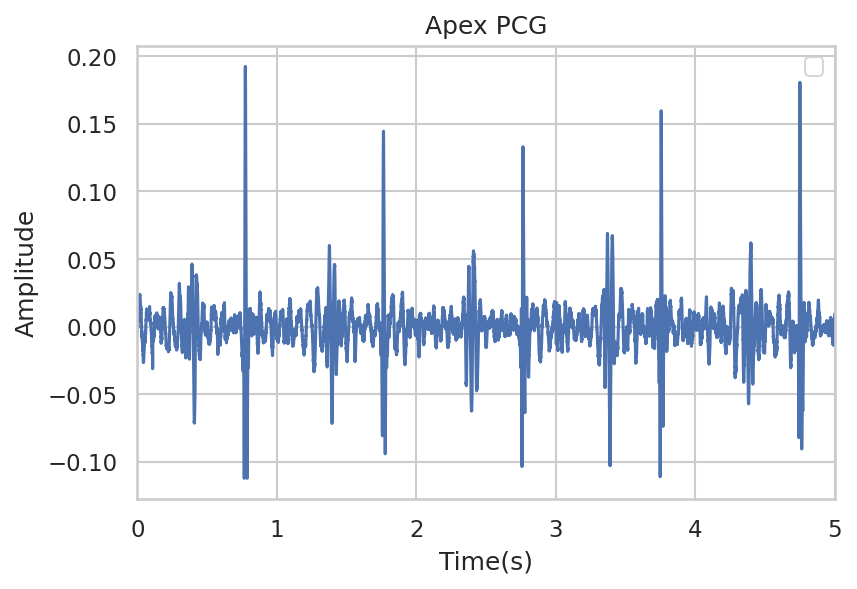

In [12]:
signal = y
title='Apex PCG'
t = np.arange(0, len(signal)/sr, 1/sr) 
fig = plt.figure(figsize=(6, 4), dpi=150) 
plt.title(title)
plt.plot(t, signal,  lw=1.5,)
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.xlim(0,  len(signal) / sr)
plt.legend()
plt.show()

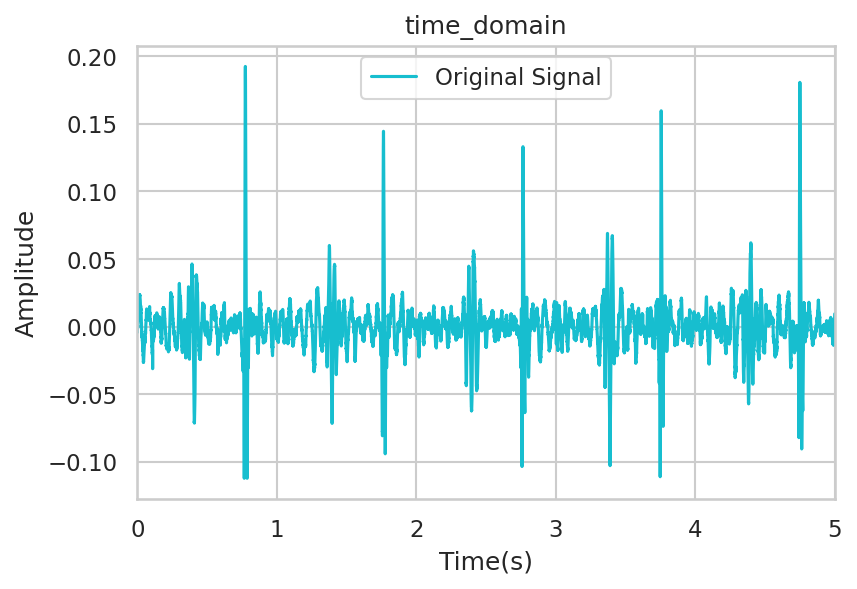

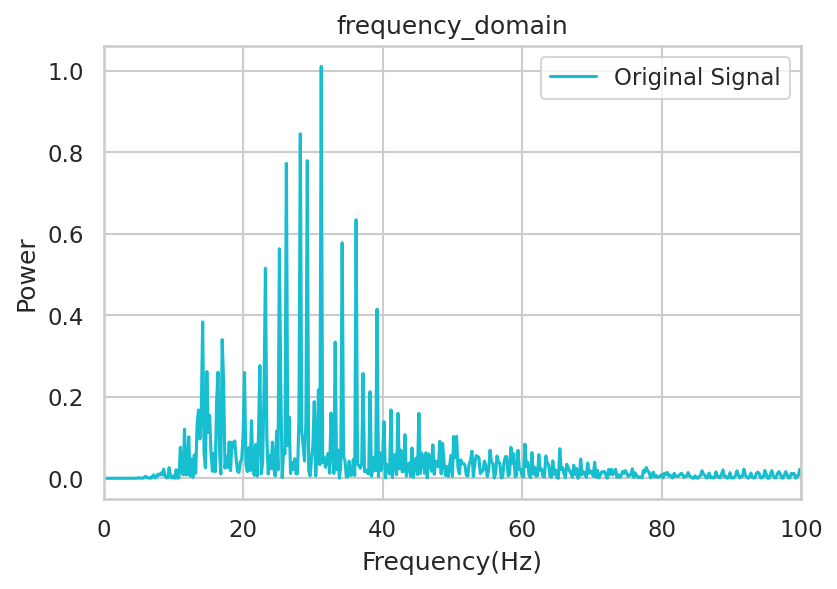

In [13]:
time_domain(y,sr,)
frequency_domain(y,sr,)

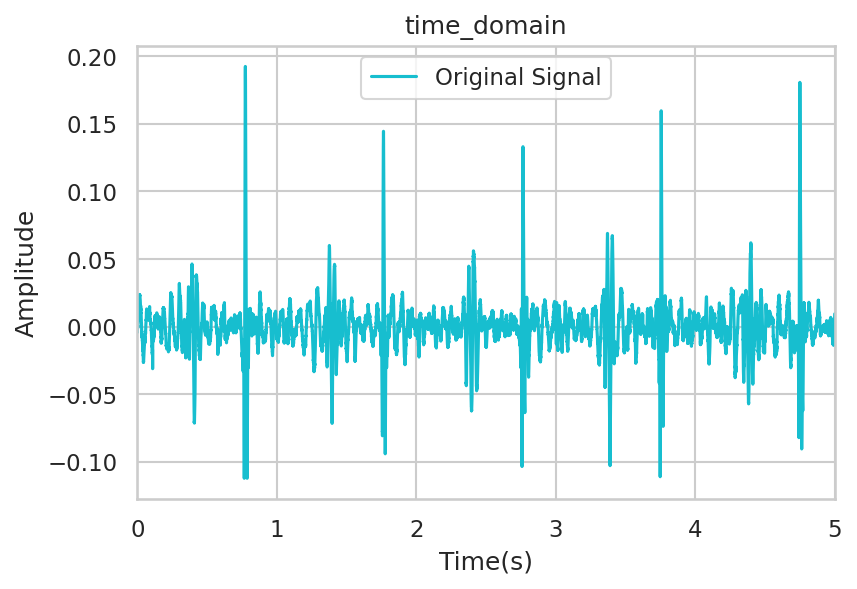

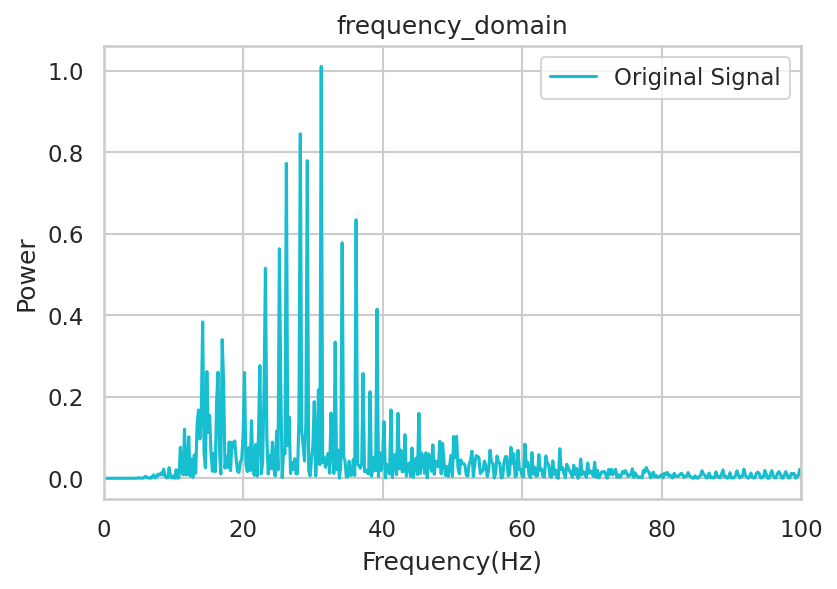

In [14]:
time_domain(y[0:sr*5],sr,)
frequency_domain(y[0:sr*5],sr,)

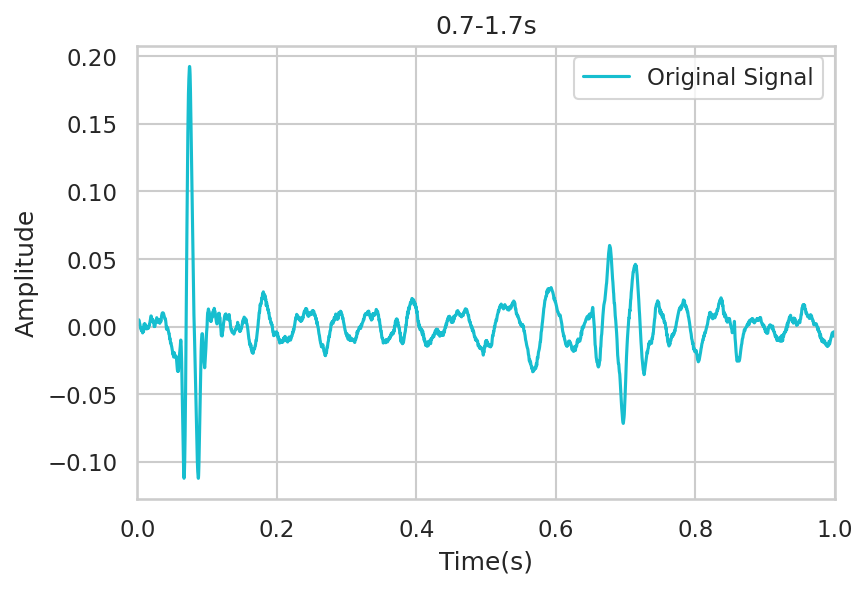

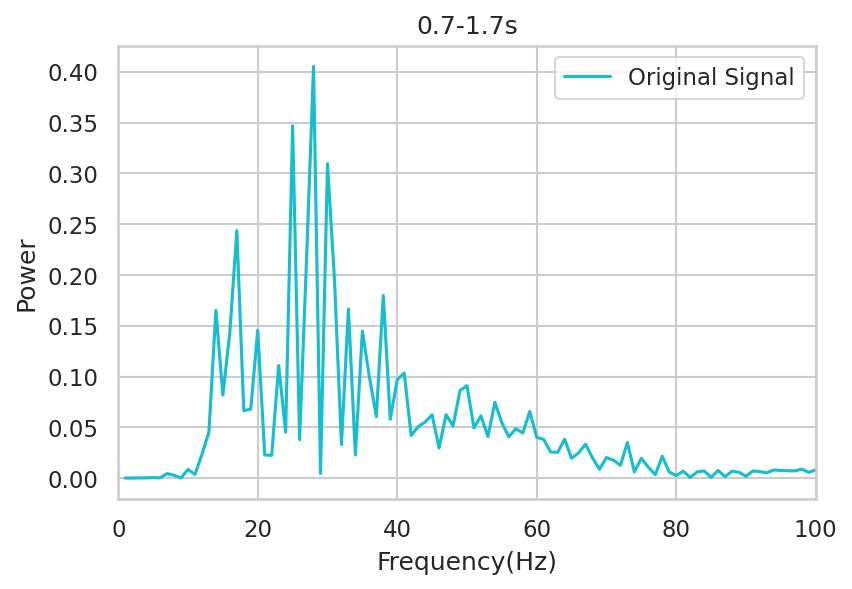

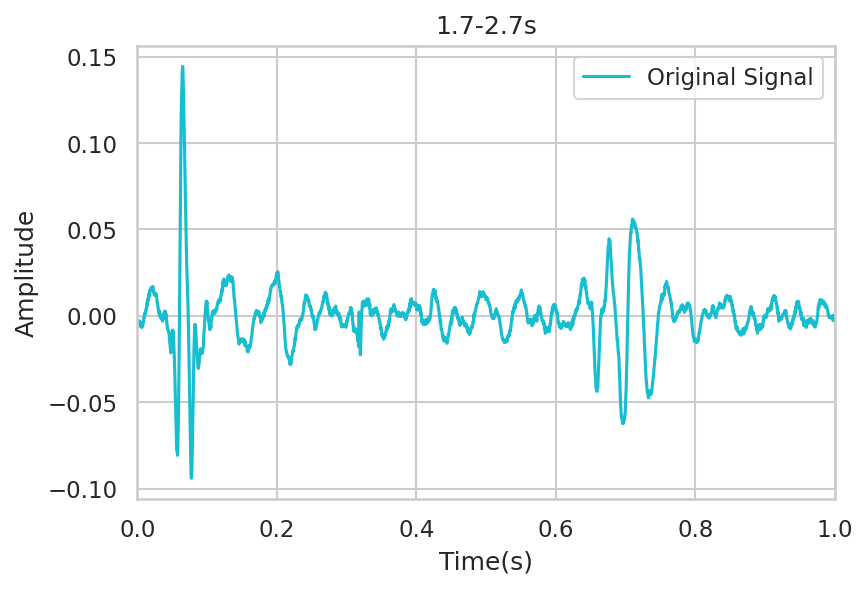

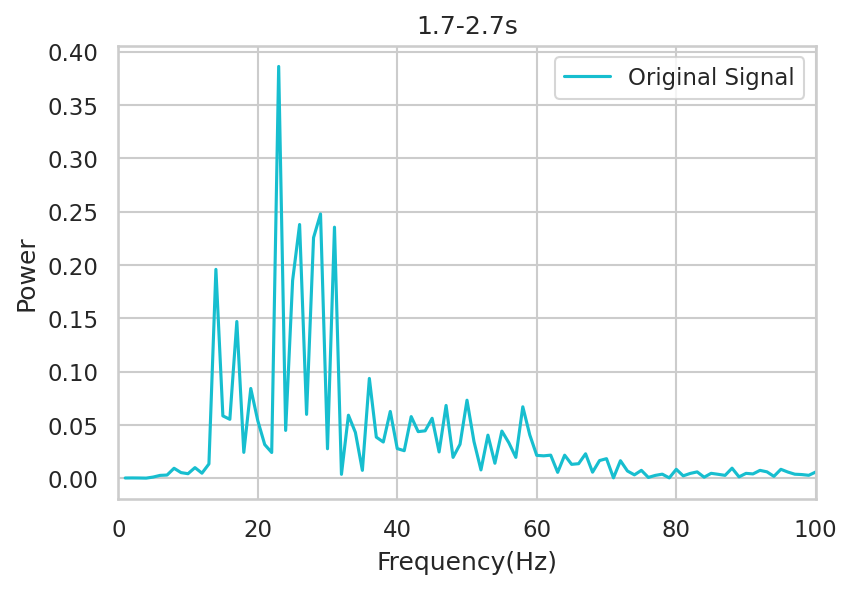

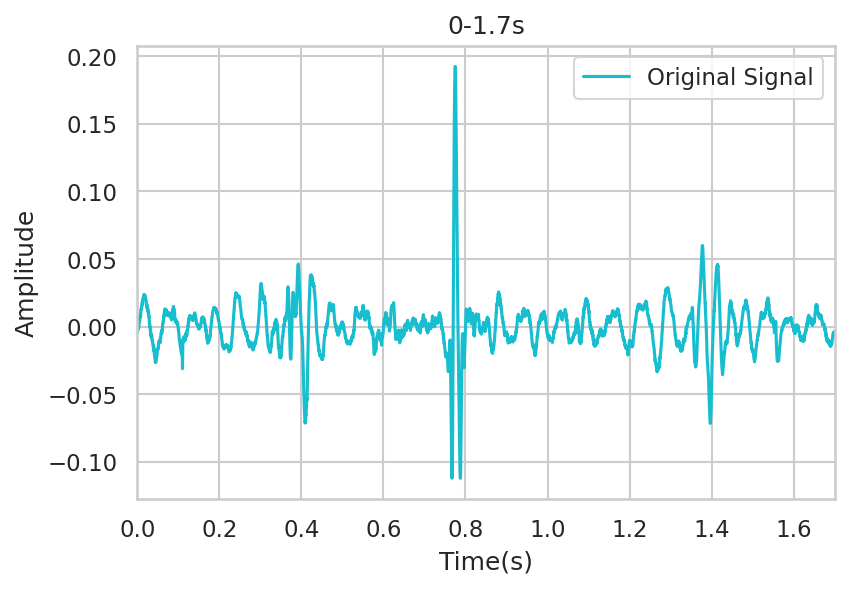

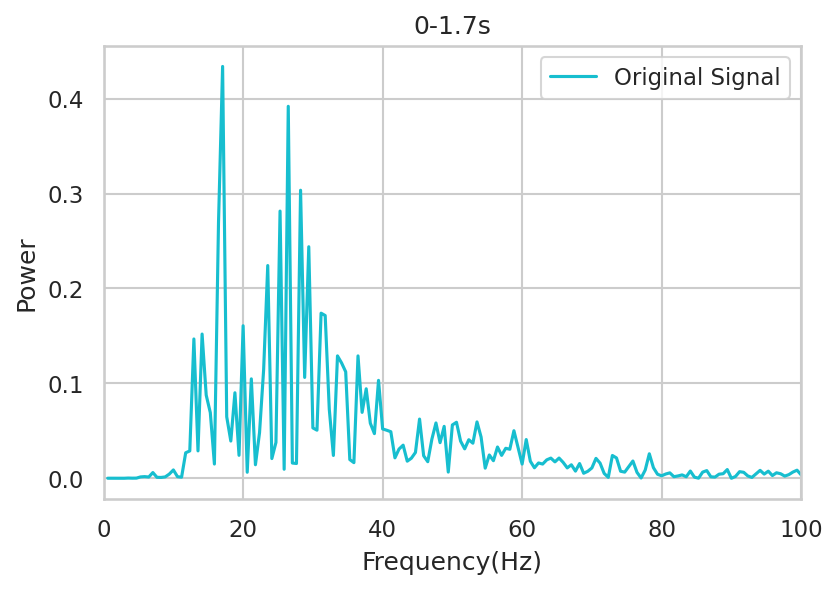

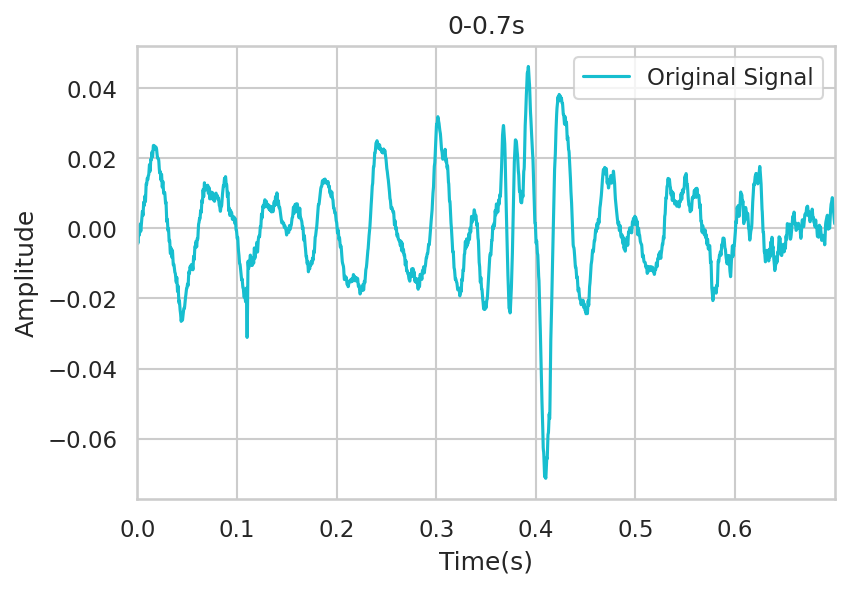

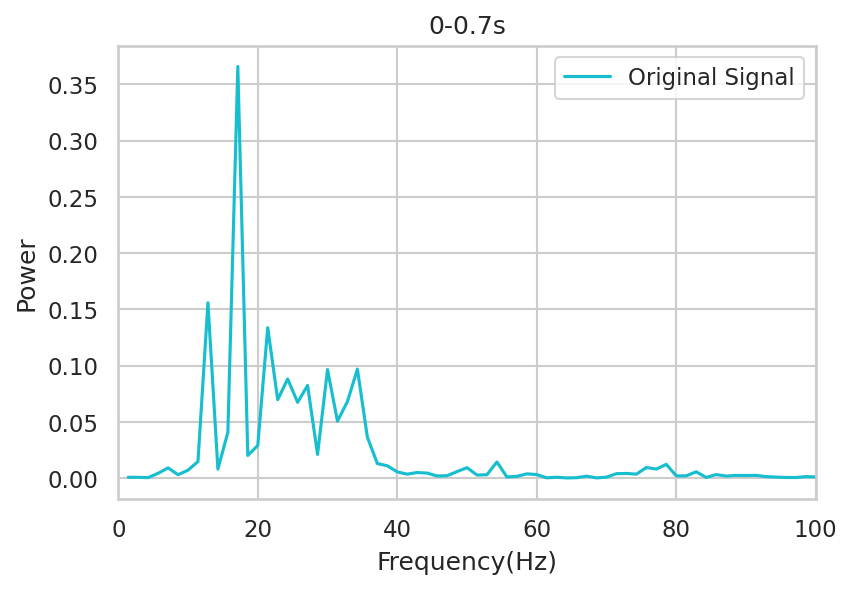

In [15]:
time_domain(y[int(sr*0.7):int(sr*1.7)],sr,'0.7-1.7s')
frequency_domain(y[int(sr*0.7):int(sr*1.7)],sr,'0.7-1.7s')
time_domain(y[int(sr*1.7):int(sr*2.7)],sr,'1.7-2.7s')
frequency_domain(y[int(sr*1.7):int(sr*2.7)],sr,'1.7-2.7s')
time_domain(y[int(sr*0):int(sr*1.7)],sr,'0-1.7s')
frequency_domain(y[int(sr*0):int(sr*1.7)],sr,'0-1.7s')
time_domain(y[int(sr*0):int(sr*0.7)],sr,'0-0.7s')
frequency_domain(y[int(sr*0):int(sr*0.7)],sr,'0-0.7s')

## 0.1计算异常整段信号的每10Hz能量分布

In [16]:
audio_path = '/media/tjubme/BFFF9639F5C15953/QiuZhaoyu/PCG/dataset-2016/abn/a0001.wav'
y, sr = librosa.load(audio_path)
print(power10_60(y,sr))
audio_path = '/media/tjubme/BFFF9639F5C15953/QiuZhaoyu/PCG/dataset-2016/abn/a0002.wav'
y, sr = librosa.load(audio_path)
print(power10_60(y,sr))
audio_path = '/media/tjubme/BFFF9639F5C15953/QiuZhaoyu/PCG/dataset-2016/abn/a0003.wav'
y, sr = librosa.load(audio_path)
print(power10_60(y,sr))

(0.08700727364452635, 0.19400905055464734, 0.10164741190458015, 0.04961067641180734, 0.032432061078657565)
(0.02673590082632109, 0.027992827418908725, 0.0429586048559813, 0.02455566782712832, 0.010662231839856972)
(0.15930226162612618, 0.2291687790062186, 0.05454344235815931, 0.01986595657880628, 0.014604311252206237)


In [17]:
# root = '/media/tjubme/BFFF9639F5C15953//QiuZhaoyu/PCG/dataset-2016/abn'
# power10_20=[]
# power20_30=[]
# power30_40=[]
# power40_50=[]
# power50_60=[]
# for file in os.listdir(root):
#     audio_root = os.path.join(root,file)
#     y, sr = librosa.load(audio_root)
#     power10_20.append(power10_60(y,sr)[0])
#     power20_30.append(power10_60(y,sr)[1])
#     power30_40.append(power10_60(y,sr)[2])
#     power40_50.append(power10_60(y,sr)[3])
#     power50_60.append(power10_60(y,sr)[4])

In [18]:
# with open(('./fulltime.csv'), mode='w', newline='') as f:
#     writer = csv.writer(f)
#     for i in range(len(power10_20)):
#         writer.writerow([power10_20[i],power20_30[i],power30_40[i],power40_50[i],power50_60[i]])

## 0.2计算异常每0.5s信号的每10Hz能量分布

In [19]:
# root = '/media/tjubme/BFFF9639F5C15953//QiuZhaoyu/PCG/dataset-2016/abn'
# power10_20=[]
# power20_30=[]
# power30_40=[]
# power40_50=[]
# power50_60=[]
# for file in os.listdir(root):
#     audio_root = os.path.join(root,file)
#     audio_data, fs = librosa.load(audio_root)
#     timelen = 0.5*fs
#     total_num = len(audio_data) / (timelen)
#     for j in range(int(total_num)):
#         audio_to_save=audio_data[int(j*timelen):int((j+1)*timelen)]
#         num_0,num_1,num_2,num_3,num_4 = power10_60(audio_to_save,sr)
#         power10_20.append(num_0)
#         power20_30.append(num_1)
#         power30_40.append(num_2)
#         power40_50.append(num_3)
#         power50_60.append(num_4)
# with open(('./0.5s.csv'), mode='w', newline='') as f:
#     writer = csv.writer(f)
#     for i in range(len(power10_20)):
#         writer.writerow([power10_20[i],power20_30[i],power30_40[i],power40_50[i],power50_60[i]])

## 0.3计算异常每1s信号的每10Hz能量分布

In [20]:
# root = '/media/tjubme/BFFF9639F5C15953//QiuZhaoyu/PCG/dataset-2016/abn'
# power10_20=[]
# power20_30=[]
# power30_40=[]
# power40_50=[]
# power50_60=[]
# for file in os.listdir(root):
#     audio_root = os.path.join(root,file)
#     audio_data, fs = librosa.load(audio_root)
#     timelen = 1*fs
#     total_num = len(audio_data) / (timelen)
#     for j in range(int(total_num)):
#         audio_to_save=audio_data[int(j*timelen):int((j+1)*timelen)]
#         num_0,num_1,num_2,num_3,num_4 = power10_60(audio_to_save,sr)
#         power10_20.append(num_0)
#         power20_30.append(num_1)
#         power30_40.append(num_2)
#         power40_50.append(num_3)
#         power50_60.append(num_4)
# with open(('./1s.csv'), mode='w', newline='') as f:
#     writer = csv.writer(f)
#     for i in range(len(power10_20)):
#         writer.writerow([power10_20[i],power20_30[i],power30_40[i],power40_50[i],power50_60[i]])

## 0.4计算异常每3s信号的每10Hz能量分布

In [21]:
# root = '/media/tjubme/BFFF9639F5C15953//QiuZhaoyu/PCG/dataset-2016/abn'
# power10_20=[]
# power20_30=[]
# power30_40=[]
# power40_50=[]
# power50_60=[]
# for file in os.listdir(root):
#     audio_root = os.path.join(root,file)
#     audio_data, fs = librosa.load(audio_root)
#     timelen = 3*fs
#     total_num = len(audio_data) / (timelen)
#     for j in range(int(total_num)):
#         audio_to_save=audio_data[int(j*timelen):int((j+1)*timelen)]
#         num_0,num_1,num_2,num_3,num_4 = power10_60(audio_to_save,sr)
#         power10_20.append(num_0)
#         power20_30.append(num_1)
#         power30_40.append(num_2)
#         power40_50.append(num_3)
#         power50_60.append(num_4)
# with open(('./3s.csv'), mode='w', newline='') as f:
#     writer = csv.writer(f)
#     for i in range(len(power10_20)):
#         writer.writerow([power10_20[i],power20_30[i],power30_40[i],power40_50[i],power50_60[i]])

## 0.5箱形图绘制

In [22]:
# full_10_20 = []
# full_20_30 = []
# full_30_40 = []
# full_40_50 = []
# full_50_60 = []

# half_10_20 = []
# half_20_30 = []
# half_30_40 = []
# half_40_50 = []
# half_50_60 = []

# one_10_20 = []
# one_20_30 = []
# one_30_40 = []
# one_40_50 = []
# one_50_60 = []

# three_10_20 = []
# three_20_30 = []
# three_30_40 = []
# three_40_50 = []
# three_50_60 = []

# with open('./fulltime.csv') as f:
#     reader = csv.reader(f)
#     for row in reader:
#         full_10_20.append(row[0])
#         full_20_30.append(row[1])
#         full_30_40.append(row[2])
#         full_40_50.append(row[3])
#         full_50_60.append(row[4])

# with open('./0.5s.csv') as f:
#     reader = csv.reader(f)
#     for row in reader:
#         half_10_20.append(row[0])
#         half_20_30.append(row[1])
#         half_30_40.append(row[2])
#         half_40_50.append(row[3])
#         half_50_60.append(row[4])

# with open('./1s.csv') as f:
#     reader = csv.reader(f)
#     for row in reader:
#         one_10_20.append(row[0])
#         one_20_30.append(row[1])
#         one_30_40.append(row[2])
#         one_40_50.append(row[3])
#         one_50_60.append(row[4])

# with open('./3s.csv') as f:
#     reader = csv.reader(f)
#     for row in reader:
#         three_10_20.append(row[0])
#         three_20_30.append(row[1])
#         three_30_40.append(row[2])
#         three_40_50.append(row[3])
#         three_50_60.append(row[4])

In [23]:
df = pd.read_csv('./data.csv')

In [24]:
df

,power,frequency,time
0,0.0,10-20Hz,0.5s
1,0.0,10-20Hz,0.5s
2,0.0,10-20Hz,0.5s
3,0.0,10-20Hz,0.5s
4,0.0,20-30Hz,0.5s
...,...,...,...
267629,NaN,NaN,NaN
267630,NaN,NaN,NaN
267631,NaN,NaN,NaN
267632,NaN,NaN,NaN


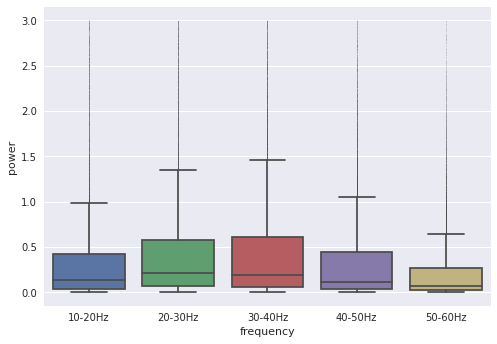

In [25]:
x = "frequency"
y = "power"
order = ['10-20Hz', '20-30Hz', '30-40Hz', '40-50Hz','50-60Hz']
with plt.style.context('seaborn'): 
    ax = sns.boxplot(data=df, x=x, y=y, order=order,fliersize=0.01)

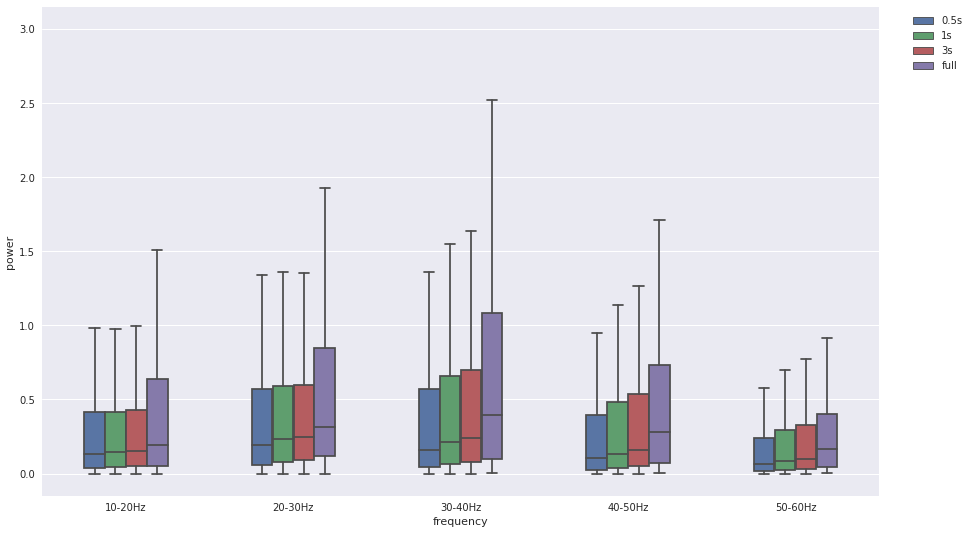

In [26]:
x = "frequency"
y = "power"
hue = "time"
hue_order=['0.5s','1s','3s', 'full']
box_pairs=[
    (("20-30Hz", "0.5s"), ("20-30Hz", "full")),
    (("20-30Hz", "0.5s"), ("20-30Hz", "3s")),
    (("20-30Hz", "0.5s"), ("20-30Hz", "full")),
#     (("30-40Hz", "0.5s"), ("30-40Hz", "3s")),
#     (("30-40Hz", "0.5s"), ("30-40Hz", "full")),
#     (("40-50Hz", "0.5s"), ("40-50Hz", "3s")),
#     (("40-50Hz", "0.5s"), ("40-50Hz", "full")),
#     (("20-30Hz", "full"), ("30-40Hz", "0.5s")),
#     (("30-40Hz", "full"), ("40-50Hz", "0.5s")),
    ]

with plt.style.context('seaborn'): 
    plt.figure(figsize=(15,9))  
    ax = sns.boxplot(data=df, x=x, y=y,orient='v', hue=hue,width=0.5,hue_order=hue_order,fliersize=0.000)
    # add_stat_annotation(ax, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs,text_format='full',
    #                     test='t-test_ind', loc='inside', comparisons_correction=None,
    #                     line_offset_to_box=0.2, line_offset=0.1, line_height=0.05, text_offset=8,
    #                     verbose=2)
    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
    plt.savefig('example_hue_layout.png', dpi=300, bbox_inches='tight')

# 1.小波去噪策略制定

## 1.1 SNR的计算与降噪评估

In [27]:
root_oringin = '/media/tjubme/BFFF9639F5C15953/QiuZhaoyu/PCG-Denoising/oringin'
root_processed = '/media/tjubme/BFFF9639F5C15953/QiuZhaoyu/PCG-Denoising/processed'
file = '1.wav'
audio_oringin,sr = librosa.load(os.path.join(root_oringin,file))
audio_processed,sr = librosa.load(os.path.join(root_processed,file))

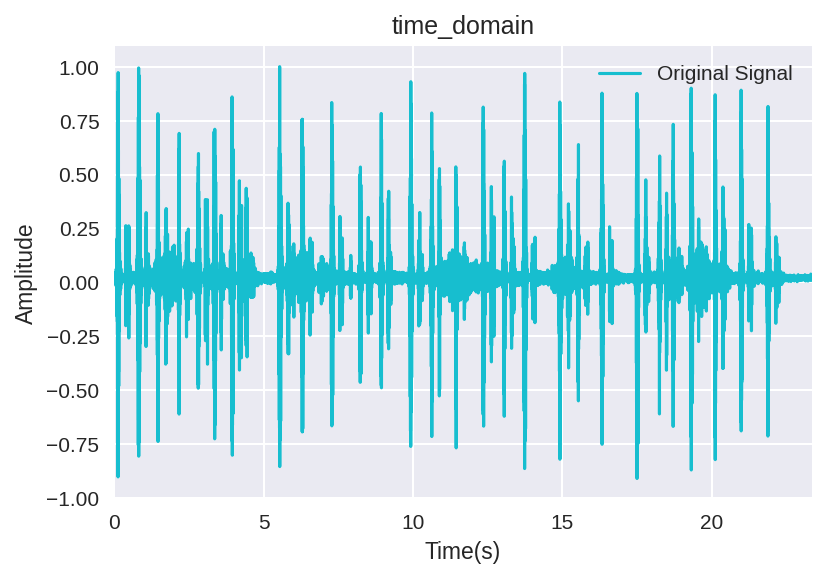

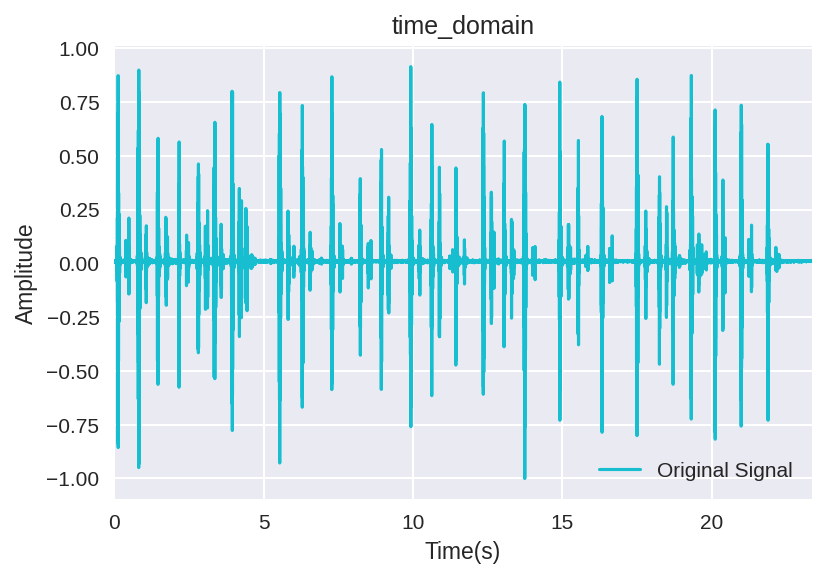

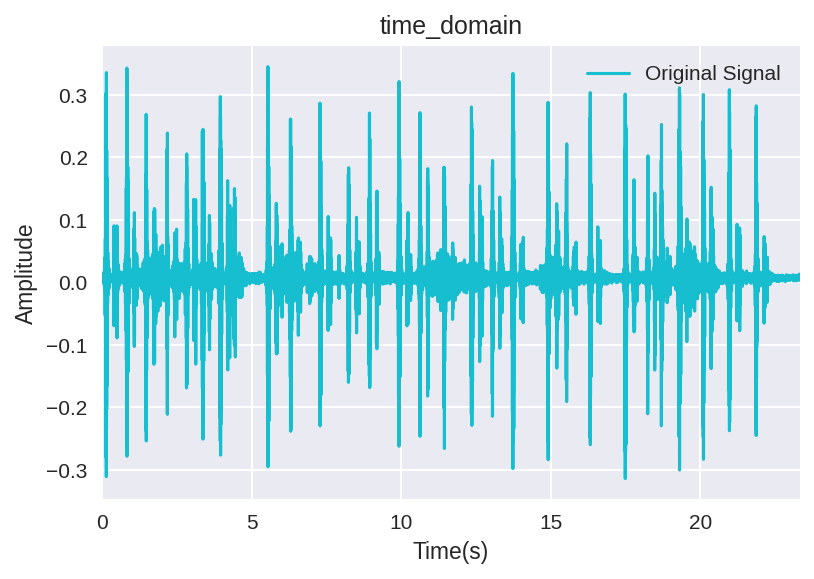

In [28]:
with plt.style.context('seaborn'): 
    time_domain(Normal(audio_oringin),sr)
    time_domain(Normal(audio_processed),sr)
    time_domain(wavelet_denoising(audio_oringin,sr,'db6',level=4),sr)

In [29]:
SNR_singlech(audio_processed,audio_oringin)

-5.559014081954956

In [30]:
SNR_singlech(audio_processed,wavelet_denoising(audio_oringin,sr,'db6',level=4))

-5.555638670921326

## 1.2小波基选择与分解层数选择
### max20%软阈值去噪

In [31]:
SNR_singlech(audio_processed,wavelet_denoising(audio_oringin,sr,'coif5',level=5))

-5.422326326370239

In [32]:
SNR_singlech(audio_processed,wavelet_denoising(audio_oringin,sr,'sym8',level=6))

-5.434434413909912

In [33]:
SNR_singlech(audio_processed,wavelet_denoising(audio_oringin,sr,'db6',level=4))

-5.555638670921326

In [70]:
Mean_SNR=[]
wavelet_base=[]
level=[]


wt_SNR,wt_core,wt_level = SNR_calculate('db6',4)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)
wt_SNR,wt_core,wt_level = SNR_calculate('db6',5)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)
wt_SNR,wt_core,wt_level = SNR_calculate('db6',6)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)
wt_SNR,wt_core,wt_level = SNR_calculate('db6',7)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)
wt_SNR,wt_core,wt_level = SNR_calculate('db6',8)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)

16.41942262649536
4.233066737651825
18.123314380645752
7.504804730415344
16.391103267669678
18.0535888671875
7.50544548034668
16.587287187576294
3.3596497774124146
18.04424285888672
15.969253778457642
4.204842448234558
17.971819639205933
16.48815393447876
4.225174784660339
18.052217960357666
16.28143548965454
4.2376551032066345
18.079148530960083
7.470755577087402
16.3864004611969
3.38913232088089
-5.649362802505493
-5.5648273229599
-7.862764000892639
-6.528193950653076
-5.993117094039917
-6.818739175796509
-6.9560253620147705
67.76640892028809
5.835874080657959
6.385523080825806
5.904340147972107
6.118525266647339
5.849878191947937
6.288994550704956
5.924392342567444
-0.7246088236570358
-0.7161813229322433
-0.7380600273609161
-0.7498886436223984
-0.738728940486908
-0.7161813229322433
-0.7246091961860657
-0.7176920771598816
-0.7246088236570358
-0.7161810249090195
-0.7380272448062897
-0.7163284718990326
-0.7277300208806992
-0.7498886436223984
-0.7385838031768799
-0.7176926732063293
-0.7

-4.409746527671814
-5.625947713851929
-2.074809819459915
--------------------
16.116414070129395
4.383694529533386
18.386136293411255
8.313953876495361
16.40642762184143
18.109687566757202
8.360298871994019
16.630462408065796
2.9212719202041626
18.898396492004395
16.28844976425171
3.8206660747528076
19.52350378036499
16.666592359542847
4.799923896789551
17.899261713027954
15.991939306259155
4.239025712013245
18.01269769668579
6.795523762702942
16.143391132354736
3.4387964010238647
-5.152772665023804
-6.824392080307007
-7.273387908935547
-6.506604552268982
-6.137515306472778
-6.335207223892212
-6.919144988059998
31.484816074371338
5.818084478378296
8.139262795448303
7.307433485984802
6.137651801109314
6.571897268295288
7.309519648551941
7.246842980384827
0.4124535620212555
-0.002567093470133841
-0.24053985252976418
-0.5109221488237381
-0.7416699826717377
-0.7670897245407104
-0.7235145568847656
-0.7526578009128571
-0.7571417093276978
-0.7715737074613571
-0.31280938535928726
-0.6231642514

In [71]:
wt_SNR,wt_core,wt_level = SNR_calculate('coif5',4)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)
wt_SNR,wt_core,wt_level = SNR_calculate('coif5',5)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)
wt_SNR,wt_core,wt_level = SNR_calculate('coif5',6)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)
wt_SNR,wt_core,wt_level = SNR_calculate('coif5',7)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)
wt_SNR,wt_core,wt_level = SNR_calculate('coif5',8)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)
wt_SNR,wt_core,wt_level = SNR_calculate('sym8',4)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)
wt_SNR,wt_core,wt_level = SNR_calculate('sym8',5)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)
wt_SNR,wt_core,wt_level = SNR_calculate('sym8',6)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)
wt_SNR,wt_core,wt_level = SNR_calculate('sym8',7)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)
wt_SNR,wt_core,wt_level = SNR_calculate('sym8',8)
Mean_SNR.append(wt_SNR)
wavelet_base.append(wt_core)
level.append(wt_level)

16.49571418762207
4.223450422286987
18.102229833602905
7.519426345825195
16.416553258895874
18.10187816619873
7.619991898536682
16.3910710811615
3.3512747287750244
17.966251373291016
16.043484210968018
4.228397607803345
18.03360342979431
16.51494264602661
4.244425892829895
18.04987668991089
16.437289714813232
4.277331233024597
18.065208196640015
7.486748099327087
16.415889263153076
3.345952033996582
-5.625698566436768
-5.554362535476685
-7.856656908988953
-6.500148177146912
-5.975607633590698
-6.738763451576233
-6.931024789810181
84.37403678894043
5.8573102951049805
6.316586136817932
5.853718519210815
6.1470335721969604
5.939730405807495
6.288615465164185
5.9282684326171875
-0.701557993888855
-0.6874221563339233
-0.7015576213598251
-0.6874221563339233
-0.7015591859817505
-0.6874218583106995
-0.7022906839847565
-0.7185286283493042
-0.6247347593307495
-0.7140502333641052
-0.6173036620020866
-0.7140498608350754
-0.7416035979986191
-0.7318631559610367
-0.695824921131134
-0.6874224543571472

-5.7275307178497314
-2.604508101940155
--------------------
16.184161901474
4.322861433029175
18.547439575195312
7.699625492095947
15.663176774978638
18.031396865844727
7.5806862115859985
15.888471603393555
4.375301003456116
16.770228147506714
15.759929418563843
4.126959443092346
17.16628670692444
17.179559469223022
3.692978322505951
17.171436548233032
17.824926376342773
3.4721121191978455
18.305002450942993
7.473794221878052
15.802302360534668
3.3377552032470703
-5.617671012878418
-5.489405393600464
-8.02990436553955
-6.576465964317322
-5.794321894645691
-7.028087377548218
-6.220141649246216
39.15405035018921
6.511526107788086
6.0096704959869385
7.052815556526184
6.182489395141602
6.255695223808289
6.681710481643677
7.992695569992065
-0.38243215531110764
-0.3809700533747673
-0.5856098607182503
-0.6932979822158813
-0.6582041829824448
-0.736132487654686
-0.5590762197971344
-0.6960665434598923
-0.3359760716557503
-0.27190495282411575
-0.023026189301162958
-0.2994050830602646
-0.544138476

-5.216132998466492
-4.407453238964081
-3.4720489382743835
-4.721198081970215
-5.5800700187683105
-2.8467053174972534
--------------------
16.37178063392639
4.265241026878357
17.287564277648926
6.88485324382782
15.596036911010742
17.262052297592163
7.478940486907959
16.6541588306427
3.353896737098694
18.162097930908203
15.181053876876831
4.049584269523621
18.199689388275146
16.55301809310913
4.258003532886505
17.982182502746582
16.469484567642212
4.200409650802612
18.016268014907837
7.510287761688232
16.385250091552734
3.3269143104553223
-5.568445920944214
-5.30292272567749
-7.46355414390564
-6.5177226066589355
-5.972354412078857
-6.783962845802307
-7.00219452381134
47.68537998199463
5.889995098114014
6.310623288154602
6.759035587310791
6.110284924507141
5.9337615966796875
6.2426722049713135
5.8930253982543945
-0.6908047199249268
-0.6948065757751465
-0.690804198384285
-0.6948068737983704
-0.6908050924539566
-0.700611025094986
-0.7180279493331909
-0.5395396053791046
-0.8149334788322449
-

-6.095553040504456
-6.712866425514221
-7.070658206939697
-8.689771890640259
-5.7536351680755615
-5.646576285362244
-4.583059549331665
-4.156185686588287
-3.6857834458351135
-4.9760401248931885
-5.299463272094727
-1.905273199081421
--------------------
16.534762382507324
3.8790446519851685
15.999699831008911
6.634318828582764
14.871976375579834
14.584448337554932
7.459803223609924
17.135640382766724
2.521265149116516
16.46204710006714
18.720157146453857
1.9244368374347687
18.205543756484985
13.788141012191772
4.381585717201233
17.40415930747986
16.507084369659424
5.055453777313232
19.513436555862427
6.990138292312622
16.817229986190796
3.393661677837372
-5.660644769668579
-5.159201622009277
-7.809797525405884
-6.378227472305298
-6.296539306640625
-6.724279522895813
-6.625416278839111
69.19739723205566
6.951085925102234
6.792954206466675
6.839929819107056
6.411526203155518
6.187635660171509
8.346295952796936
6.975638270378113
-0.7628784328699112
-0.6226422637701035
-0.6507207453250885
-0

In [72]:
df = pd.DataFrame({
    "SNR":Mean_SNR,
    "wavelet_base":wavelet_base,
    "Level":level
})
 
df

,SNR,wavelet_base,Level
0,4.842219,db6,4
1,4.893083,db6,5
2,5.102157,db6,6
3,5.355111,db6,7
4,5.295299,db6,8
5,4.977585,coif5,4
6,4.921934,coif5,5
7,5.241794,coif5,6
8,5.251833,coif5,7
9,5.343600,coif5,8


In [73]:
df.to_csv('base&level.csv')

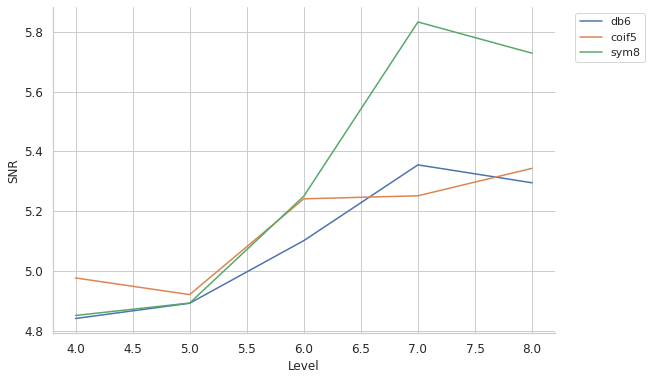

In [37]:
plt.figure(figsize=(9,6))  
sns.lineplot(x="Level", y="SNR", hue="wavelet_base",data=df)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.set_style("ticks")
sns.despine() #去掉不必要的边框
plt.savefig('base&level', dpi=600, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(9,6),dpi=600)  
sns.lineplot(x="Level", y="SNR", hue="wavelet_base",data=df)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Choice of wavelet base and layers.',fontsize=20)
sns.set_style("ticks")
sns.despine() #去掉不必要的边框
plt.savefig('base&level', dpi=600, bbox_inches='tight')

## 1.4 阈值选择

In [38]:
SNR_calculate_14(threshold=0.2,mode='self',a=2)

16.344358921051025
8.044602870941162
15.21669626235962
5.711400508880615
19.31845784187317
13.885674476623535
7.0727622509002686
14.357714653015137
5.0037360191345215
13.09232473373413
25.740070343017578
3.929077684879303
31.280028820037842
21.481845378875732
1.1048424988985062
29.674065113067627
27.405097484588623
2.6266857981681824
52.9911994934082
6.668150424957275
35.76138734817505
2.6264598965644836
-7.214926481246948
-5.348914861679077
-9.633083939552307
-9.038119912147522
-6.044816970825195
-7.5574564933776855
-6.986055374145508
4.994686543941498
25.16235589981079
14.292116165161133
16.642273664474487
5.900760889053345
12.7167809009552
18.313872814178467
14.837712049484253
5.8181679248809814
3.6472907662391663
3.8264933228492737
3.8777104020118713
1.6982655227184296
4.547074139118195
5.279214978218079
5.813319683074951
2.4641531705856323
2.9923558235168457
4.803459346294403
4.280480742454529
3.5975849628448486
3.6445152759552
3.7320032715797424
2.326423227787018
1.91170245409011

(7.718052275938122, 'self', 0.2)

In [39]:
SNR_calculate_14(threshold=0.2,mode='hard',a=.5)

17.073310613632202
2.7021971344947815
17.70240068435669
6.905852556228638
15.68702220916748
14.515421390533447
7.456437349319458
17.193790674209595
3.1813886761665344
18.238524198532104
15.295424461364746
3.146505057811737
18.138591051101685
16.52702808380127
4.238385558128357
16.910773515701294
16.641353368759155
5.067335367202759
19.518489837646484
7.275899052619934
16.510121822357178
4.042856395244598
-5.571684241294861
-4.947332441806793
-7.816380262374878
-6.282864212989807
-6.448293328285217
-6.709922552108765
-6.56557023525238
91.90618515014648
7.179875373840332
6.805106997489929
6.995328068733215
6.3395291566848755
6.268335580825806
8.366904258728027
6.905869841575623
-0.7892266660928726
-0.6168244406580925
-0.5951977521181107
-0.7454826682806015
-0.4133196920156479
-0.5564745515584946
0.731755867600441
0.49508173018693924
-0.730598047375679
-0.32852504402399063
-0.4205136001110077
-0.2363743633031845
-0.4046107456088066
-0.1941070891916752
-0.4620248079299927
-0.43912794440984

(5.832332806176927, 'hard', 0.2)

In [40]:
SNR_calculate_14(threshold=0.2,mode='soft',a=.5)

6.8258583545684814
0.2801724523305893
8.57782244682312
0.5302075669169426
5.2730125188827515
10.21945834159851
2.576436400413513
6.98559045791626
-0.4319394752383232
10.401936769485474
7.186709642410278
-0.6661407649517059
7.8394615650177
9.766646027565002
-1.1694971472024918
7.6739150285720825
6.863054037094116
-1.6012224555015564
7.613586187362671
1.781633347272873
2.8558191657066345
-1.2273447960615158
-7.861895561218262
-6.496798396110535
-9.859566688537598
-9.557186961174011
-8.037967681884766
-8.753384351730347
-8.790587186813354
11.627084016799927
2.032926380634308
2.0800070464611053
1.428408920764923
-0.24254854768514633
1.2414859980344772
2.8186315298080444
1.5722283720970154
-2.9650625586509705
-2.7050793170928955
-2.904433012008667
-3.184226155281067
-3.1015801429748535
-2.3505952954292297
-2.6596274971961975
-2.8588390350341797
-2.832239270210266
-2.756134569644928
-2.7314868569374084
-3.2040104269981384
-3.0519449710845947
-3.0094996094703674
-3.644310235977173
-3.14120948

(0.8459283782915556, 'soft', 0.2)

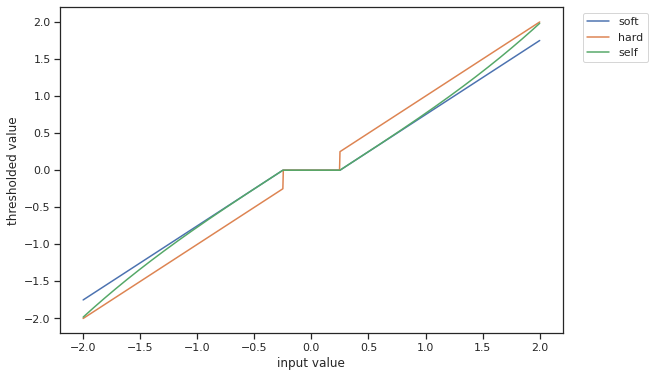

In [41]:
s = np.linspace(-2, 2, 1000)

s_soft = pywt.threshold(s, value=2/8, mode='soft')
s_hard = pywt.threshold(s, value=2/8, mode='hard')
# s_garrote = pywt.threshold(s, value=0.5, mode='garrote')
# s_firm1 = pywt.threshold_firm(s, value_low=0.5, value_high=1)
# s_firm2 = pywt.threshold_firm(s, value_low=0.5, value_high=2)
# s_firm3 = pywt.threshold_firm(s, value_low=0.5, value_high=4)

self = self_threshold(s,t=1/8,a=2)

plt.figure(figsize=(9,6))  
plt.plot(s, s_soft)
plt.plot(s, s_hard)
plt.plot(s, self)
# plt.legend()
plt.xlabel('input value')
plt.ylabel('thresholded value')
plt.legend(['soft', 'hard', 'self'],loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('self&hard&soft', dpi=300, bbox_inches='tight')

In [42]:
SNR_calculate_14(threshold=0.2,mode='self',a=1)

6.629079580307007
5.67244291305542
2.0758511126041412
12.300318479537964
3.009825348854065
2.040415108203888
11.2857985496521
7.396552562713623
7.729347348213196
1.9553859531879425
3.495190441608429
10.92283844947815
3.3509790897369385
3.0206871032714844
38.08778762817383
4.805796146392822
4.329519271850586
6.872934699058533
4.663344919681549
12.371258735656738
2.023167908191681
38.06906700134277
-0.4145723208785057
3.002253472805023
-6.286846995353699
-2.233920842409134
3.240446448326111
-3.697144091129303
0.20171187818050385
0.3937583416700363
1.8979229032993317
1.2611787021160126
1.349102258682251
5.297185182571411
1.2275215983390808
1.852709949016571
1.4664636552333832
5.240960121154785
6.24830961227417
6.228553056716919
6.350389122962952
9.389809370040894
6.067981123924255
5.622183680534363
5.331710577011108
7.231340408325195
6.712638735771179
5.784485340118408
6.268357038497925
6.980116963386536
7.067528963088989
6.720591187477112
8.843504190444946
9.134549498558044
5.15670061111

(3.1197085241748863, 'self', 0.2)

In [43]:
SNR_calculate_14(threshold=0.2,mode='self',a=3)

9.933462738990784
3.178475499153137
16.72776222229004
2.459501177072525
8.347383737564087
20.253729820251465
3.588223159313202
9.726199507713318
1.7449766397476196
22.63129949569702
13.498961925506592
0.5126488953828812
12.756857872009277
14.568703174591064
-0.37668466567993164
12.569516897201538
11.255240440368652
0.1500305812805891
13.629515171051025
3.4164437651634216
8.479257822036743
0.43762173503637314
-7.783253192901611
-6.718820929527283
-10.25942087173462
-10.198040008544922
-7.585410475730896
-8.230867981910706
-7.953563928604126
12.557408809661865
8.558364510536194
10.87134838104248
10.074465274810791
1.5077747404575348
13.634302616119385
10.934938192367554
12.322328090667725
-0.20878031849861145
-1.6125354170799255
-1.4468833804130554
-1.3062350451946259
-2.2822384536266327
-0.7079152762889862
-0.3587133437395096
-0.11762089096009731
-2.2846946120262146
-2.0085351169109344
-0.7706824690103531
-0.964830070734024
-1.2466759979724884
-1.147192120552063
-1.1936905235052109
-1.6

(5.055492941851485, 'self', 0.2)

In [44]:
SNR_calculate_14(threshold=0.2,mode='self',a=4)

8.323971629142761
2.2541695833206177
10.556998252868652
1.439482569694519
6.092449426651001
12.5114107131958
2.5246676802635193
8.455098867416382
0.7555220276117325
13.43288779258728
9.713922142982483
-0.5320543795824051
9.467898607254028
10.253543853759766
-0.8608666062355042
9.991552829742432
8.68773877620697
-0.6343909353017807
10.602254867553711
2.422720193862915
5.679190158843994
-0.28090938925743103
-7.981499433517456
-7.1939921379089355
-10.479762554168701
-10.50452470779419
-8.12329113483429
-8.465030789375305
-8.288109302520752
25.228822231292725
4.679480493068695
5.959791541099548
5.149582028388977
0.7213450223207474
7.065708041191101
6.245243549346924
6.746246814727783
-2.023432105779648
-2.4222353100776672
-2.5705575942993164
-2.8549724817276
-3.106100559234619
-2.3221223056316376
-2.0605355501174927
-1.9027967751026154
-2.5468000769615173
-2.396800220012665
-2.490057349205017
-2.5944480299949646
-2.7726083993911743
-2.656811475753784
-2.7067267894744873
-2.799924314022064


(2.7555362031195467, 'self', 0.2)

In [45]:
SNR_calculate_14(threshold=0.2,mode='self',a=5)

7.641202211380005
1.8463444709777832
8.499480485916138
0.9888292849063873
5.175502300262451
10.18592357635498
2.0587533712387085
7.907092571258545
0.3178449720144272
10.877563953399658
8.277749419212341
-0.9054072201251984
8.212026357650757
8.673336505889893
-1.0795337706804276
8.980752229690552
7.656397819519043
-0.9904193133115768
9.418742060661316
1.9780603051185608
4.55071896314621
-0.6067708134651184
-8.073159456253052
-7.413423657417297
-10.581971406936646
-10.550060272216797
-8.372387886047363
-8.573169708251953
-8.442309498786926
26.487243175506592
3.175140917301178
4.432254731655121
3.2991737127304077
0.3714875504374504
4.81782853603363
4.4835734367370605
4.751453995704651
-2.8374475240707397
-2.525818645954132
-2.6857808232307434
-2.981404662132263
-3.1060895323753357
-2.6661190390586853
-2.824440598487854
-2.7004262804985046
-2.610918879508972
-2.4739283323287964
-2.614775598049164
-3.2229962944984436
-3.2104861736297607
-2.914678454399109
-3.3895879983901978
-3.143332600593

(1.6665051050391686, 'self', 0.2)

In [46]:
SNR_calculate_14(threshold=0.2,mode='self',a=.5)

0.4592214524745941
0.30686207115650177
0.06530504208058119
0.6937545537948608
0.08776913397014141
0.06506839767098427
0.8950094133615494
0.5222460627555847
0.2984582260251045
0.06039920262992382
0.19872771576046944
0.6323350220918655
0.1490261871367693
0.13499789871275425
1.2952318787574768
0.2966023050248623
0.20432354882359505
0.290236659348011
0.31942009925842285
0.8748066425323486
0.04290971904993057
1.4542855322360992
4.350409209728241
3.9278826117515564
31.610872745513916
5.933266878128052
3.3793866634368896
11.765381097793579
4.111952781677246
0.0020289859094191343
0.03790613962337375
0.018349537858739495
0.019857219886034727
0.2045038342475891
0.01788398250937462
0.0423944927752018
0.025405623018741608
0.20522389560937881
0.2566765621304512
0.2572738379240036
0.26601819321513176
0.44496458023786545
0.25054626166820526
0.22592250257730484
0.21028954535722733
0.3066903352737427
0.280257873237133
0.2361714281141758
0.2651863917708397
0.30668359249830246
0.31227558851242065
0.28686

(0.7988204527661253, 'self', 0.2)

24.605720043182373
20.66986322402954
8.442617654800415
13.80607008934021
15.108928680419922
8.26965868473053
14.63531494140625
38.1353759765625
8.553298711776733
7.86881148815155
12.006903886795044
9.966679811477661
12.471728324890137
10.983672142028809
5.054093599319458
15.73499321937561
15.123672485351562
10.331964492797852
14.095773696899414
14.452652931213379
12.005748748779297
7.235404849052429
-5.327287316322327
-3.0353042483329773
-8.615758419036865
-6.7602550983428955
-4.234994649887085
-6.140218377113342
-5.406578779220581
3.124372661113739
10.763328075408936
7.629973888397217
8.488999009132385
13.120777606964111
7.355642318725586
9.670844078063965
8.158334493637085
13.807066679000854
9.944869875907898
10.173548460006714
10.261962413787842
6.727796792984009
11.184186935424805
12.418051958084106
13.480690717697144
7.888748049736023
8.709636330604553
11.8394136428833
10.673388242721558
9.461751580238342
9.401031136512756
9.909239411354065
7.2278207540512085
6.895387172698975
14.

11.025893688201904
4.866396486759186
27.240383625030518
3.062985837459564
10.614019632339478
20.216124057769775
4.570727348327637
9.886852502822876
3.6839529871940613
19.49344038963318
23.750107288360596
1.5869121253490448
19.671883583068848
27.23881959915161
-0.5713090300559998
16.618963479995728
15.12648344039917
0.27087192982435226
18.492145538330078
4.050954580307007
14.430316686630249
0.5737172812223434
-8.24398934841156
-6.485137343406677
-10.092687606811523
-10.205626487731934
-7.154862880706787
-8.19520354270935
-7.984824180603027
6.481058597564697
21.11395835876465
24.52059268951416
39.85111951828003
3.0949237942695618
19.148343801498413
58.253021240234375
25.85474967956543
3.1227853894233704
1.346023678779602
1.536003053188324
1.6025832295417786
-0.3529418632388115
2.077438235282898
2.695286273956299
3.198600113391876
0.3419128432869911
0.797547772526741
2.2980695962905884
1.8231618404388428
1.22703917324543
1.4311367273330688
1.4472673833370209
0.18012650310993195
-0.1114251

-11.407632827758789
-11.223044395446777
-11.380704641342163
-9.681457281112671
-9.174271821975708
-7.609933018684387
--------------------
1.6451308131217957
0.8196267485618591
6.117313504219055
-3.00434947013855
-1.2211048603057861
10.3624427318573
-1.1162424832582474
1.3015994429588318
0.3002496063709259
7.953428030014038
5.299878120422363
-3.7347057461738586
4.147255122661591
4.9543944001197815
-4.263901710510254
4.0620094537734985
2.7628403902053833
-2.8569969534873962
4.29873913526535
-2.29343518614769
1.0550981014966965
-2.850339114665985
-11.226723194122314
-9.97853934764862
-11.980733871459961
-11.58597707748413
-10.695016384124756
-11.007694005966187
-11.26754641532898
21.171257495880127
2.6152971386909485
6.27787709236145
4.4316476583480835
-2.787202000617981
8.223908543586731
6.524919271469116
6.459084153175354
-3.272499144077301
-3.4343570470809937
-3.6969703435897827
-3.790138065814972
-3.1453144550323486
-3.09509813785553
-3.1080979108810425
-3.4425315260887146
-3.64183306

-6.096582412719727
-6.635730266571045
-7.077322006225586
-7.916131019592285
-5.663735866546631
-5.743575096130371
-5.3087592124938965
-4.164045453071594
-3.7847548723220825
-4.920262694358826
-5.3770363330841064
-1.7932665348052979
--------------------
17.073310613632202
2.7021971344947815
17.70240068435669
6.905852556228638
15.68702220916748
14.515421390533447
7.456437349319458
17.193790674209595
3.1813886761665344
18.238524198532104
15.295424461364746
3.146505057811737
18.138591051101685
16.52702808380127
4.238385558128357
16.910773515701294
16.641353368759155
5.067335367202759
19.518489837646484
7.275899052619934
16.510121822357178
4.042856395244598
-5.571684241294861
-4.947332441806793
-7.816380262374878
-6.282864212989807
-6.448293328285217
-6.709922552108765
-6.56557023525238
91.90618515014648
7.179875373840332
6.805106997489929
6.995328068733215
6.3395291566848755
6.268335580825806
8.366904258728027
6.905869841575623
-0.7892266660928726
-0.6168244406580925
-0.5951977521181107
-0

10.741150379180908
17.56183385848999
13.961116075515747
13.398598432540894
12.012479305267334
14.099940061569214
10.914506912231445
-9.475789070129395
-6.520625352859497
-6.039718389511108
-5.94104528427124
-7.193407416343689
-9.058103561401367
-6.663856506347656
-5.46861469745636
-4.355786442756653
-4.281898140907288
-5.880790948867798
-6.037144064903259
-4.390060305595398
-1.133822649717331
--------------------
17.045129537582397
3.1328022480010986
13.15860390663147
5.155810117721558
15.92765212059021
14.019842147827148
6.8579936027526855
18.984118700027466
3.558351993560791
18.484715223312378
14.305458068847656
3.348655104637146
12.475944757461548
17.803386449813843
4.523007273674011
19.157451391220093
16.63257122039795
4.611733555793762
18.95203948020935
6.966466307640076
13.458430767059326
4.492751955986023
-5.032984018325806
-4.878822565078735
-7.858008146286011
-6.569392085075378
-5.9098827838897705
-5.440866947174072
-5.493118762969971
42.38287925720215
8.876752853393555
8.1545

9.496278762817383
8.33855390548706
9.093918204307556
9.614394903182983
9.84093725681305
7.646503448486328
9.917960166931152
9.80273723602295
8.833916187286377
9.354546666145325
11.24191164970398
8.940072059631348
-10.644800662994385
-8.265801668167114
-7.653053402900696
-8.385790586471558
-9.336192011833191
-10.382509231567383
-8.15750241279602
-7.313649654388428
-6.977105736732483
-5.927491188049316
-5.782374143600464
-7.156548500061035
-6.633140444755554
-3.848876953125
--------------------
8.84044885635376
0.840926468372345
10.362166166305542
2.148236483335495
7.430495023727417
11.509957313537598
3.720312714576721
8.988595008850098
-0.13540678657591343
11.997573375701904
8.856357336044312
0.31411565840244293
9.8222815990448
11.153421401977539
0.13244562782347202
9.577187895774841
8.823803663253784
-0.014549478655681014
9.810462594032288
3.0820587277412415
5.471440553665161
0.0740487314760685
-7.396243214607239
-6.111600995063782
-9.779002666473389
-8.70596170425415
-7.83870458602905

7.118405699729919
4.95064377784729
8.039638996124268
5.284109115600586
4.532251954078674
5.777405500411987
7.19771683216095
7.319909334182739
3.6113443970680237
6.210183501243591
7.700449824333191
5.8454060554504395
5.775376558303833
9.636732935905457
5.688135623931885
-12.217968702316284
-11.6282057762146
-10.085386037826538
-10.923783779144287
-12.629896402359009
-13.173084259033203
-9.906518459320068
-9.648357629776001
-9.556043148040771
-8.822516202926636
-8.801894187927246
-9.608798623085022
-8.285043835639954
-6.259810924530029
--------------------
3.1165942549705505
-0.40970999747514725
5.495138168334961
-2.266100198030472
1.4211498200893402
8.554613590240479
0.503096878528595
3.1298986077308655
-0.9035651385784149
7.299677729606628
4.420579671859741
-2.542741596698761
4.39594179391861
7.3502349853515625
-3.194214403629303
4.232165217399597
3.388155698776245
-4.1039615869522095
3.754032552242279
-0.7330293953418732
-1.5418589115142822
-3.586716949939728
-9.211494326591492
-7.327

11.25630259513855
-5.90533971786499
4.18068528175354
3.700729012489319
5.8235180377960205
1.3634932041168213
3.3436137437820435
0.1742994599044323
4.439250230789185
4.146455228328705
1.8913379311561584
5.684522390365601
2.432040423154831
1.8302720785140991
4.178988337516785
4.530152082443237
5.521804094314575
0.40805015712976456
2.717396914958954
5.129878520965576
2.3948225378990173
2.8213435411453247
7.990442514419556
3.889414668083191
-14.083784818649292
-14.37880277633667
-12.606772184371948
-14.558662176132202
-15.618836879730225
-15.162795782089233
-11.922223567962646
-12.476013898849487
-12.30262041091919
-12.121361494064331
-10.781769752502441
-11.502319574356079
-11.115325689315796
-9.088391661643982
--------------------


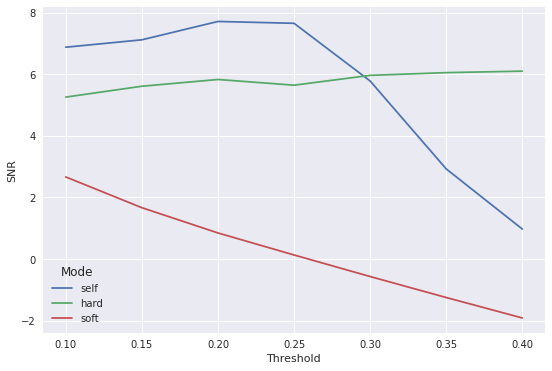

In [47]:
Mean_SNR=[]
mode=[]
threshold=[]


wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.1,mode='self',a=2)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.15,mode='self',a=2)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.2,mode='self',a=2)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.25,mode='self',a=2)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.3,mode='self',a=2)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.35,mode='self',a=2)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.4,mode='self',a=2)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)

wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.1,mode='hard',a=2)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.15,mode='hard',a=2)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.2,mode='hard',a=2)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.25,mode='hard',a=2)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.3,mode='hard',a=2)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.35,mode='hard',a=3)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.4,mode='hard',a=3)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)

wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.1,mode='soft',a=3)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.15,mode='soft',a=3)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.2,mode='soft',a=3)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.25,mode='soft',a=3)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.3,mode='soft',a=3)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.35,mode='soft',a=3)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)
wt_SNR,wt_mode,wt_threshold = SNR_calculate_14(threshold=0.4,mode='soft',a=3)
Mean_SNR.append(wt_SNR)
mode.append(wt_mode)
threshold.append(wt_threshold)

df = pd.DataFrame({
    "SNR":Mean_SNR,
    "Mode":mode,
    "Threshold":threshold
})
 
with plt.style.context('seaborn'): 
    plt.figure(figsize=(9,6))  
    sns.lineplot(x="Threshold", y="SNR", hue="Mode",data=df)

In [68]:
df

,SNR,Mode,Threshold
0,6.881197,self,0.10
1,7.121921,self,0.15
2,7.718052,self,0.20
3,7.658138,self,0.25
4,5.783733,self,0.30
5,2.926191,self,0.35
6,0.971828,self,0.40
7,5.260229,hard,0.10
8,5.613377,hard,0.15
9,5.832333,hard,0.20


In [69]:
df.to_csv('self&threshold.csv')

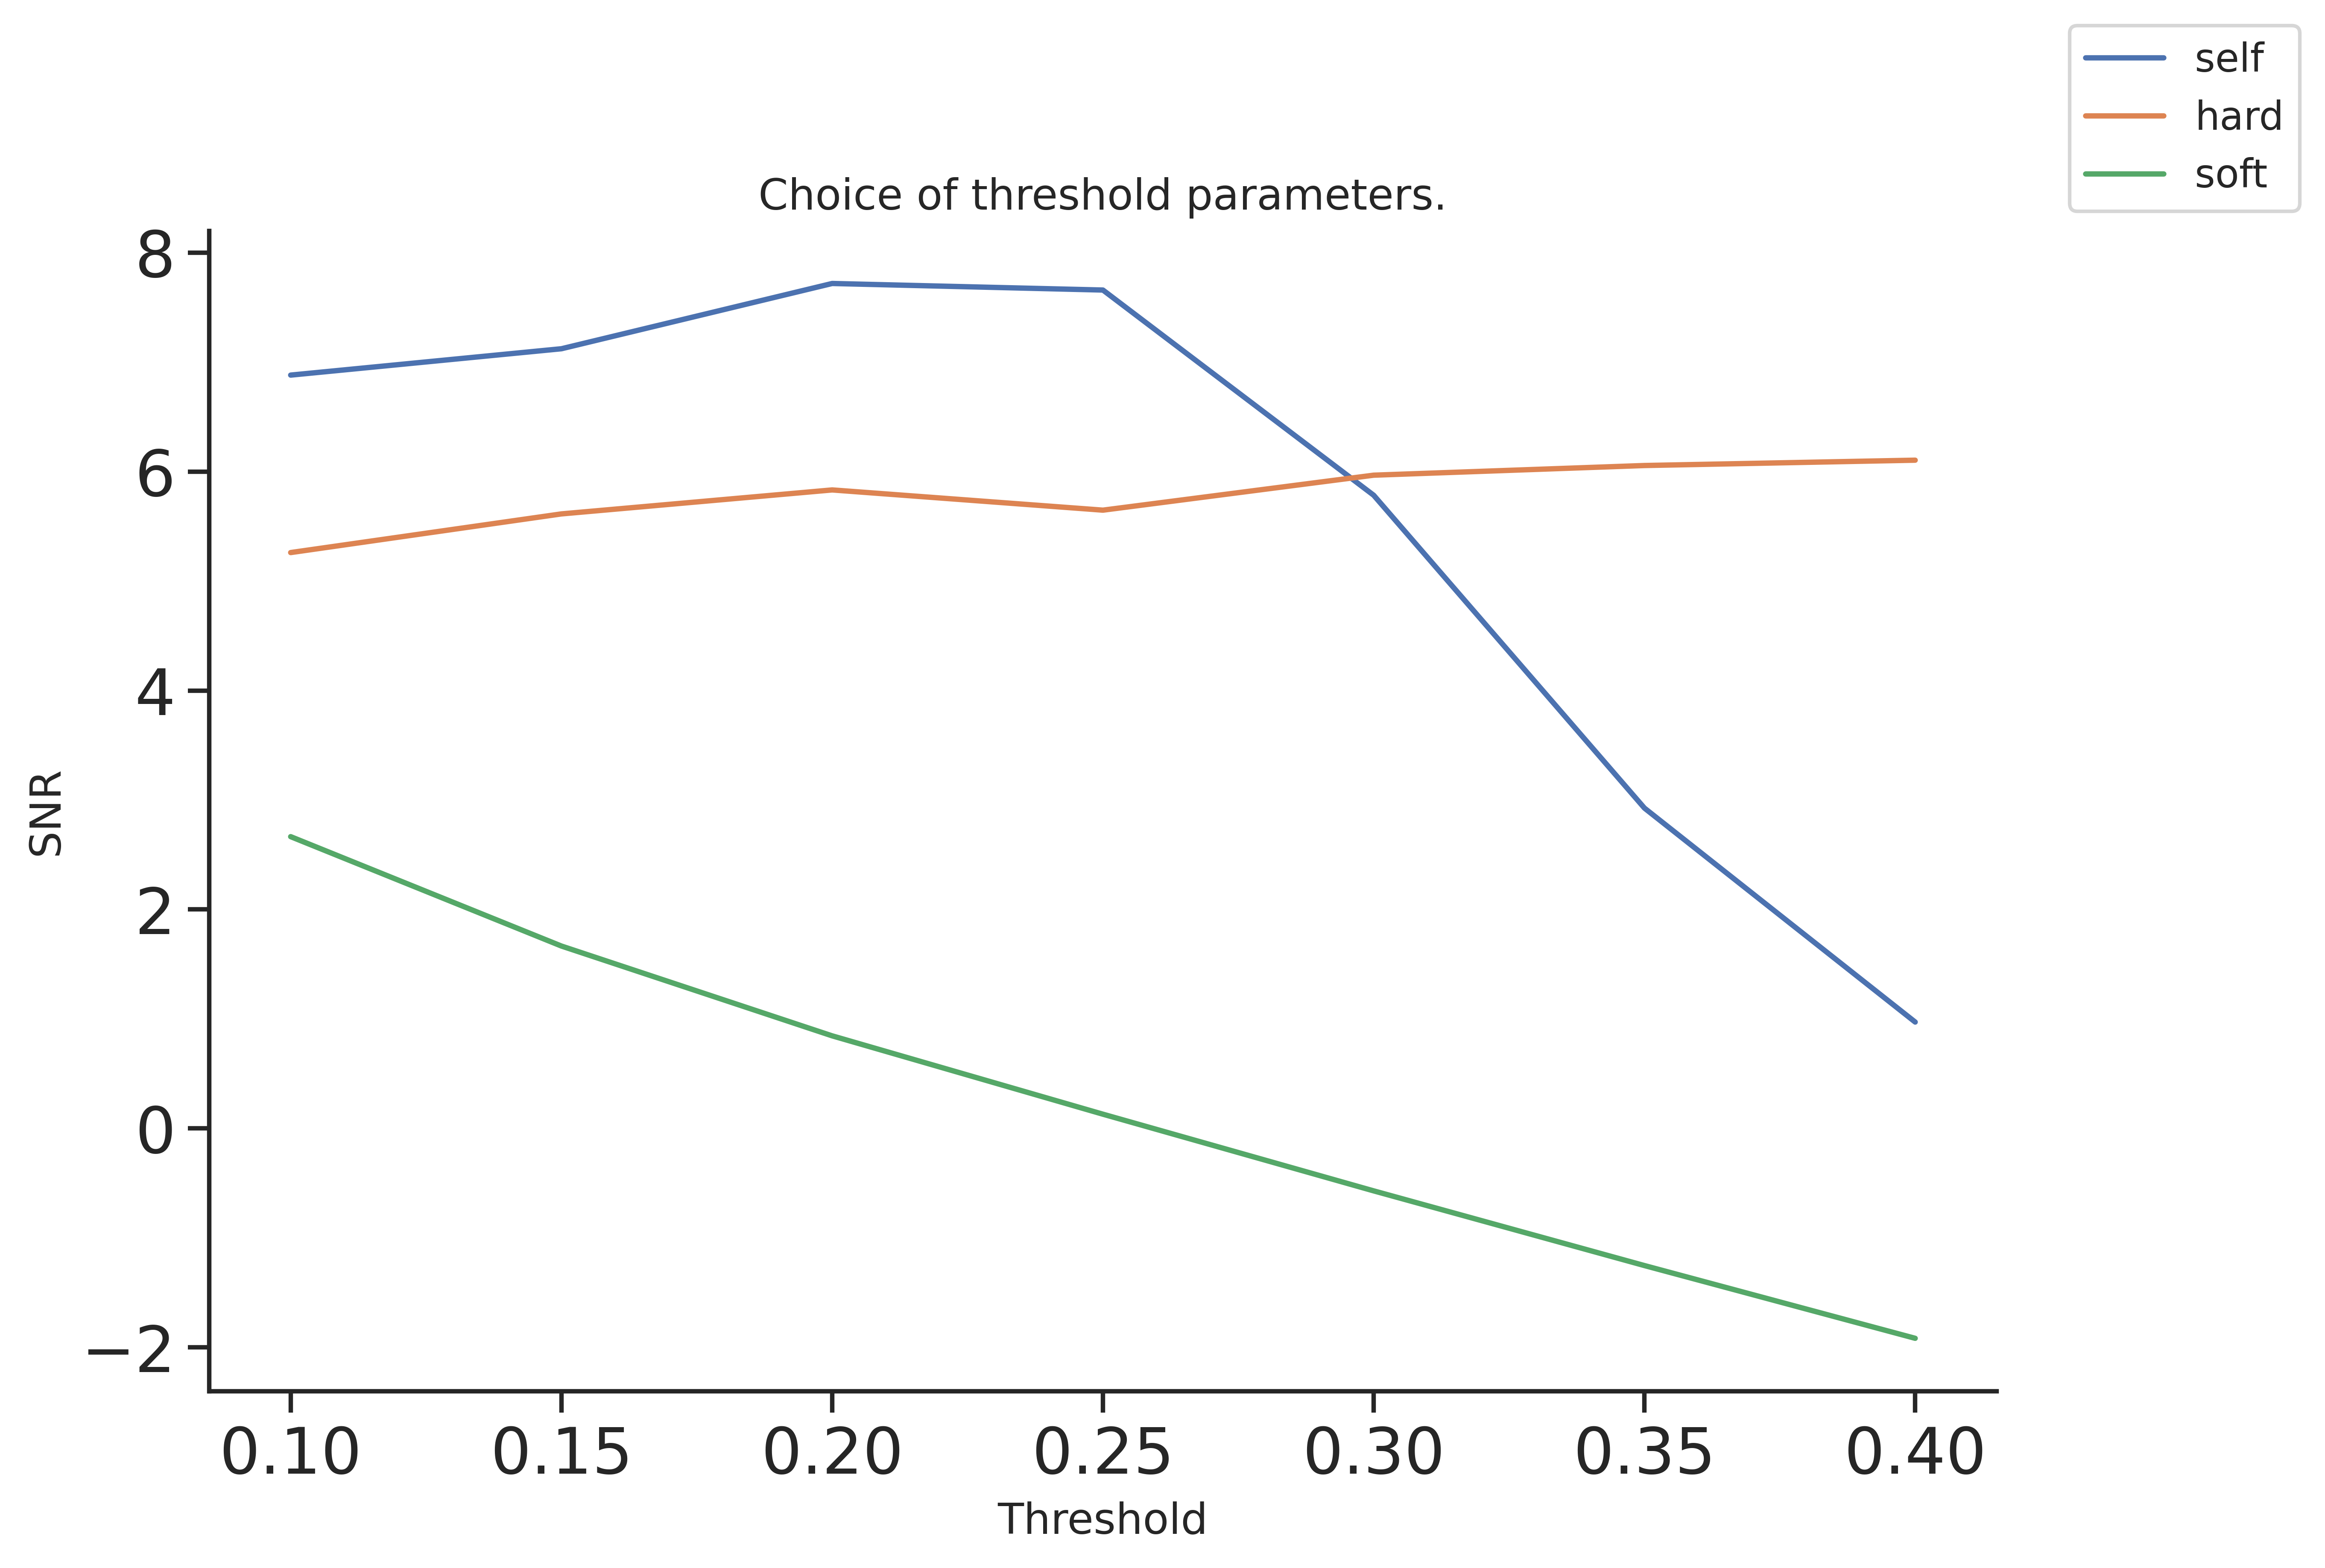

In [66]:
plt.figure(figsize=(9,6),dpi=600)  
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
sns.lineplot(x="Threshold", y="SNR", hue="Mode",data=df)

plt.legend(loc='lower left', bbox_to_anchor=(1.03, 1))
# plt.tick_params(axis='both',which='both',direction='in')

plt.title('Choice of threshold parameters.')
sns.set_style("ticks")
sns.despine() #去掉不必要的边框
plt.savefig('self&threshold', dpi=600, bbox_inches='tight')

In [94]:
ResNet_test_loss=[6.881196846,
7.121921467,
7.718052276,
7.658138472,
5.783732988,
2.926190942,
0.971827728
]
MobileNet_test_loss=[5.260228914,
5.613376992,
5.832332806,
5.647585743,
5.967033361,
6.055329555,
6.104046502
]
DenseNet_test_loss=[2.66541873,
1.666208437,
0.845928378,
0.130262098,
-0.570100528,
-1.252319888,
-1.91680774
]

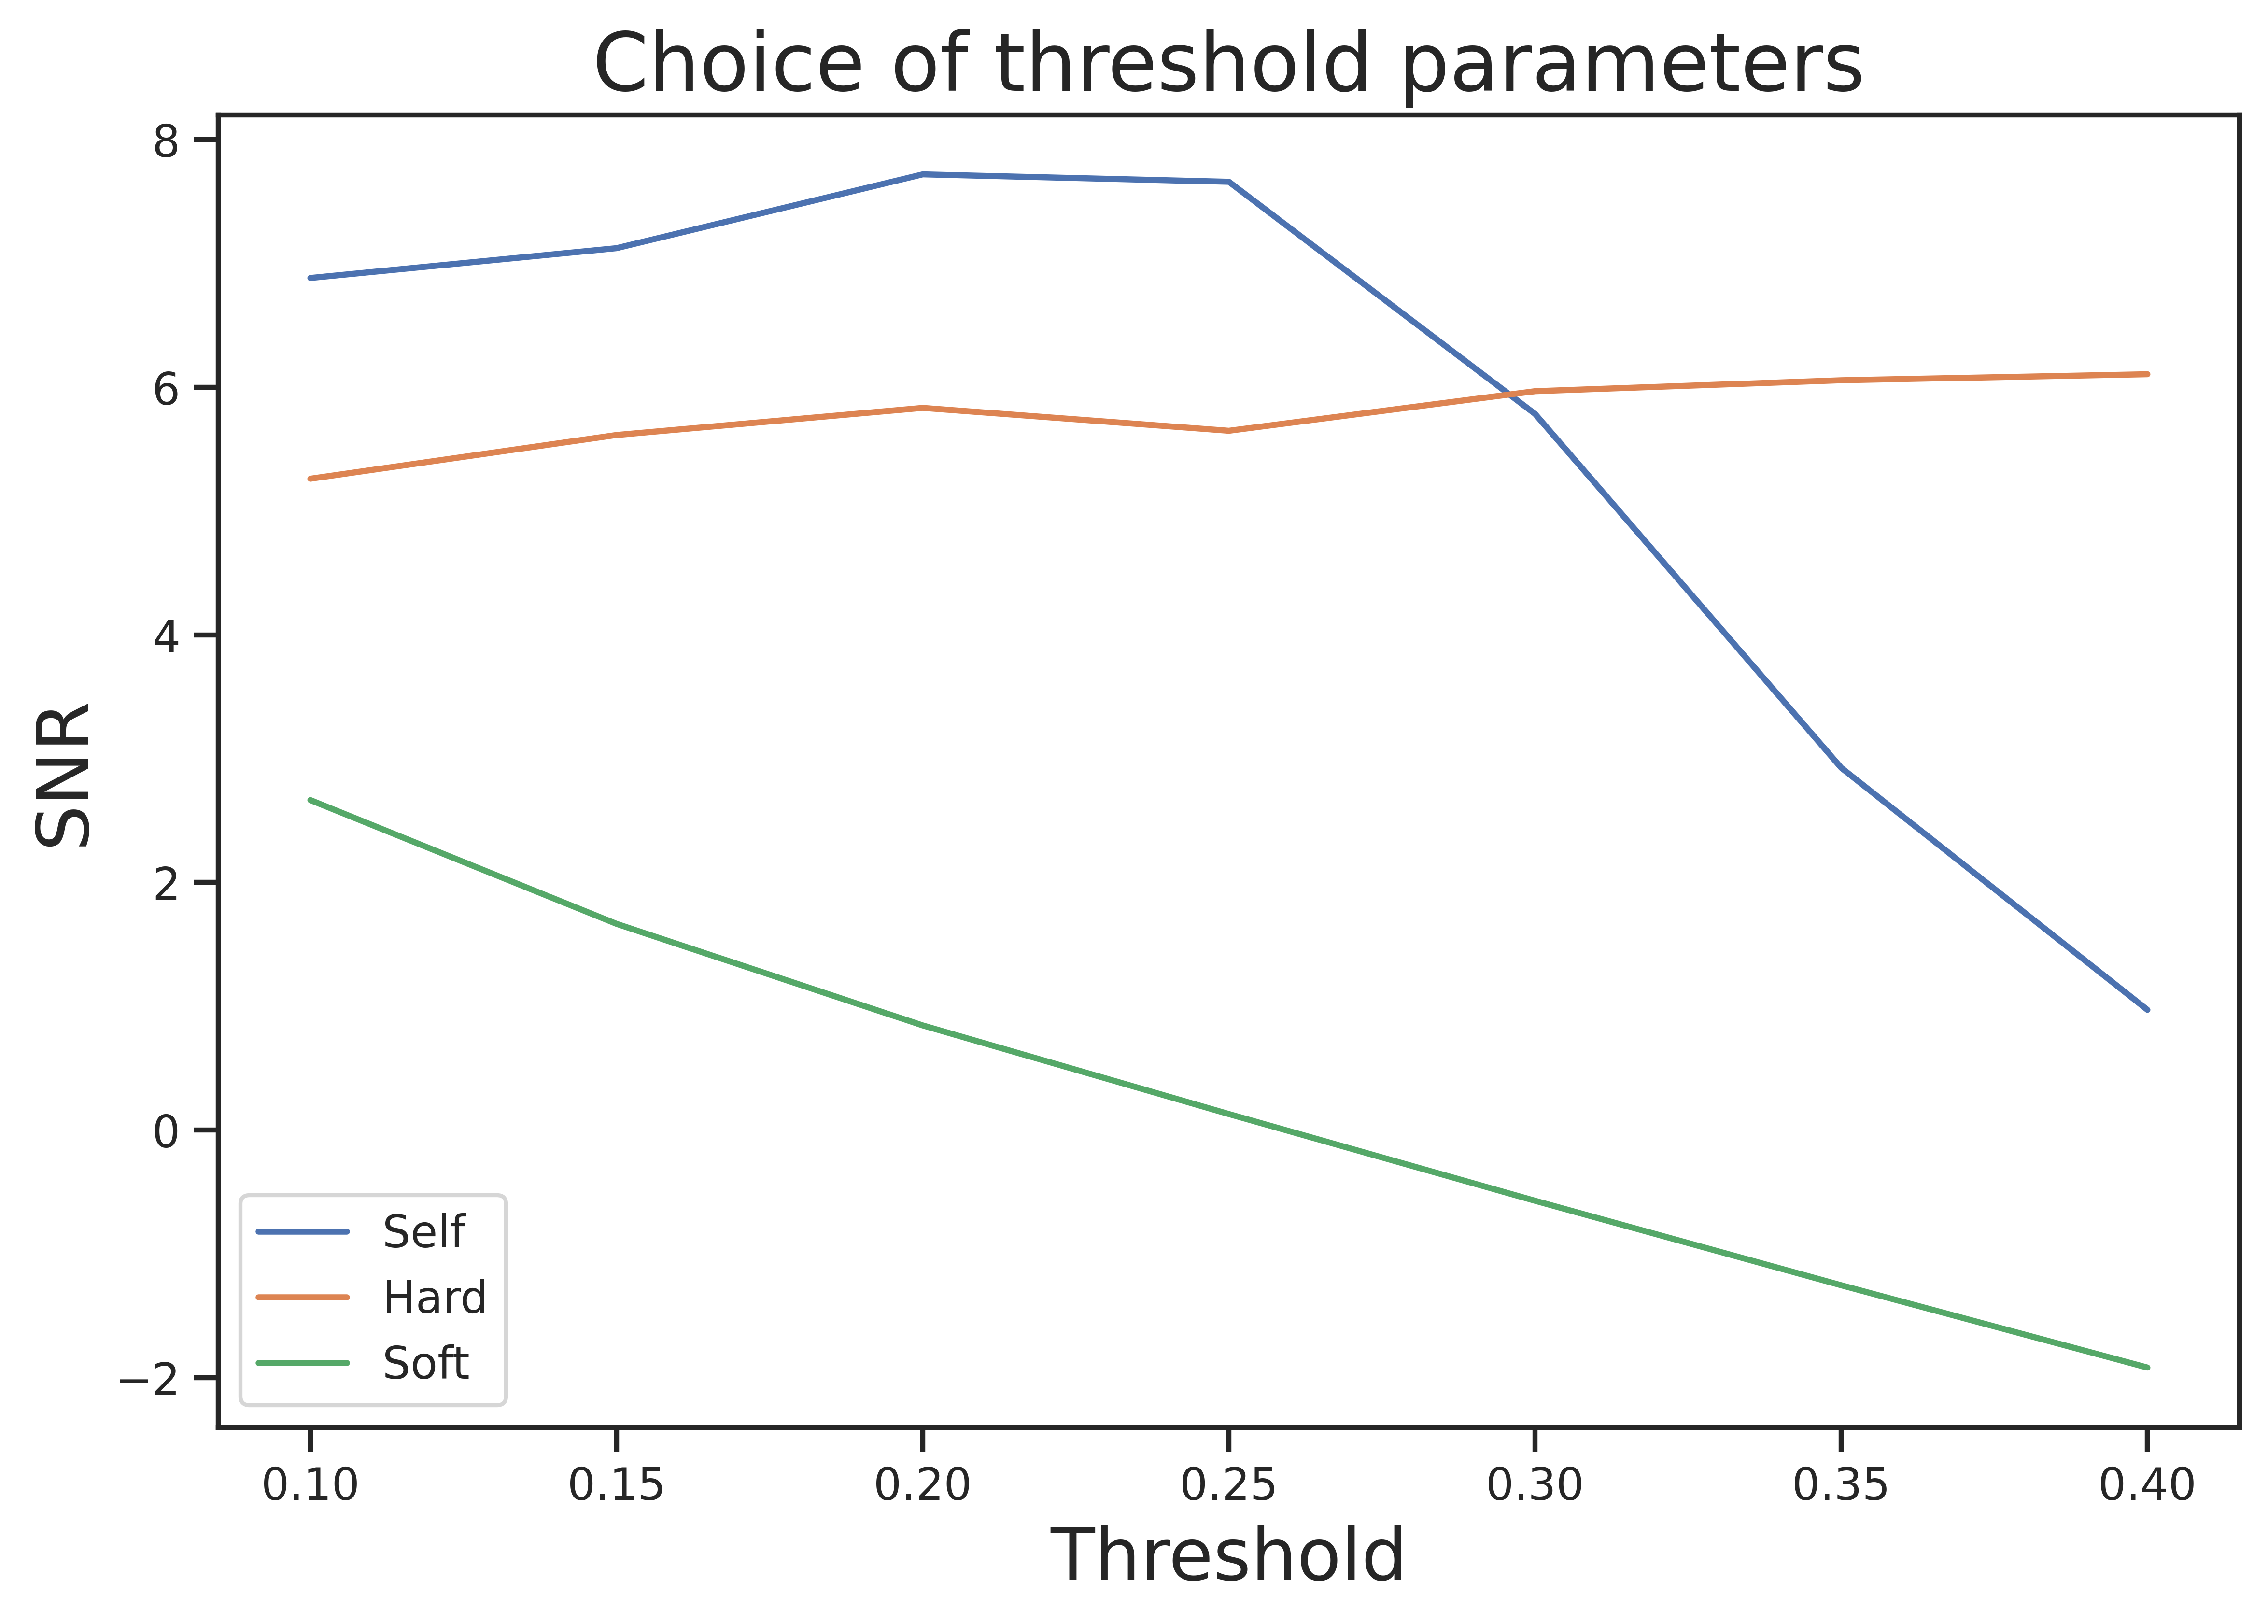

In [95]:
fig=plt.figure(figsize=(9,6),dpi=600)
epoch_list = [0.1,0.15,0.2,0.25,0.3,0.35,0.4]
plt.plot(epoch_list,ResNet_test_loss) 
plt.plot(epoch_list,MobileNet_test_loss)
plt.plot(epoch_list,DenseNet_test_loss)
plt.xlabel("Threshold",fontsize=18)
plt.ylabel("SNR",fontsize=18)
plt.legend(['Self', 'Hard','Soft'], loc='lower left')
plt.title('Choice of threshold parameters',fontsize=20)
sns.set_style("ticks")
# sns.despine() #去掉不必要的边框
plt.savefig('self_threshold.png', dpi=600, bbox_inches='tight')
plt.show()

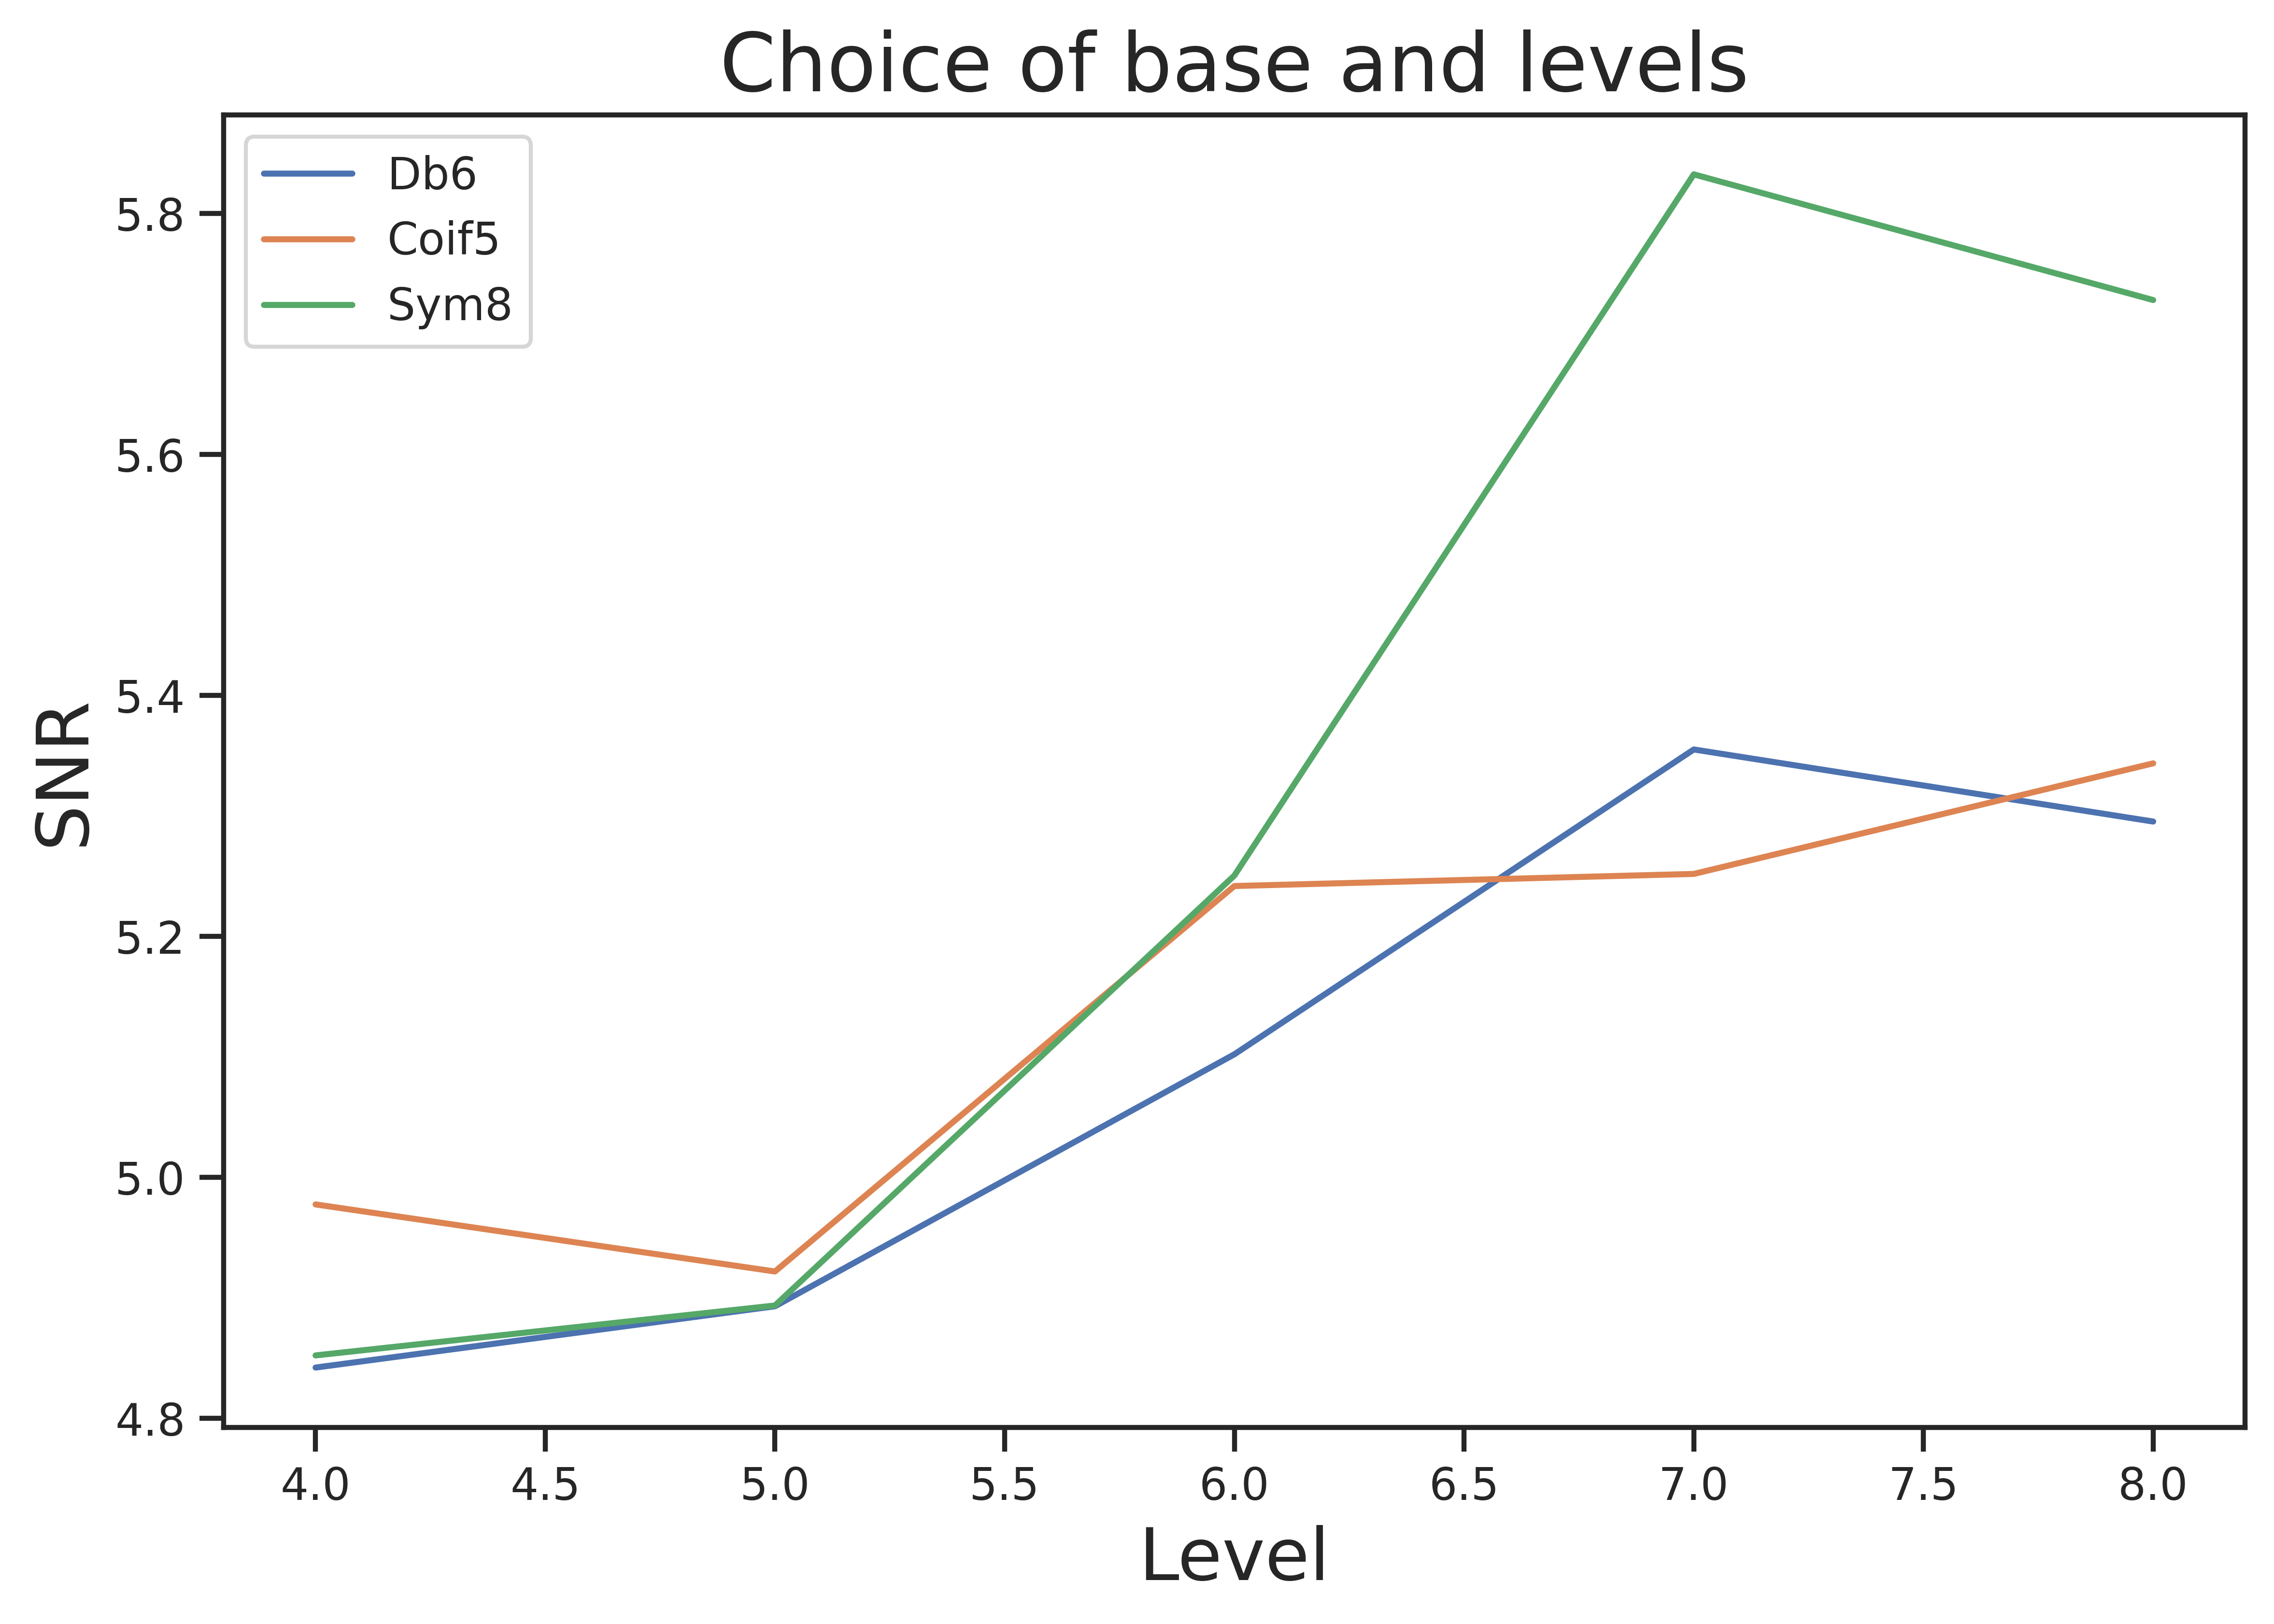

In [96]:
ResNet_test_loss=[4.842219216,
4.893083055,
5.102156965,
5.355110876,
5.295298758
]
MobileNet_test_loss=[4.977584716,
4.921934414,
5.241793852,
5.251832822,
5.34360019
]
DenseNet_test_loss=[4.852302411,
4.893708271,
5.250521718,
5.832332806,
5.728034433
]
fig=plt.figure(figsize=(9,6),dpi=600)
epoch_list = [4,5,6,7,8]
plt.plot(epoch_list,ResNet_test_loss) 
plt.plot(epoch_list,MobileNet_test_loss)
plt.plot(epoch_list,DenseNet_test_loss)
plt.xlabel("Level",fontsize=18)
plt.ylabel("SNR",fontsize=18)
plt.legend(['Db6', 'Coif5','Sym8'], loc='upper left')
plt.title('Choice of base and levels',fontsize=20)
sns.set_style("ticks")
# sns.despine() #去掉不必要的边框
plt.savefig('base_level.png', dpi=600, bbox_inches='tight')
plt.show()